In [ ]:
# Copyright 2021 NVIDIA CORPORATION
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt, time
import cudf, numpy as np, pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import cupy, gc
cudf.__version__

'0.19.1'

In [2]:
VER = 217
TRAIN_SUB = True
SEED = 0
POSTFIX = 'a'
FLIP = False

In [3]:
# ALL OF GIBA PREPROCESS FEATURES
ALL = ['hashtags', 'tweet_id', 'media', 'links', 'domains', 'tweet_type',
       'language', 'timestamp', 'a_user_id', 'a_follower_count',
       'a_following_count', 'a_is_verified', 'a_account_creation', 'b_user_id',
       'b_follower_count', 'b_following_count', 'b_is_verified',
       'b_account_creation', 'b_follows_a', 'reply', 'retweet',
       'retweet_comment', 'like', 'text', 'tw_len_media', 'tw_len_photo',
       'tw_len_video', 'tw_len_gif', 'tw_len_quest', 'tw_len_token',
       'tw_count_capital_words', 'tw_count_excl_quest_marks',
       'tw_count_special1', 'tw_count_hash', 'tw_last_quest', 'tw_len_retweet',
       'tw_len_rt', 'tw_count_at', 'tw_count_words', 'tw_count_char',
       'tw_rt_count_words', 'tw_rt_count_char', 'tw_original_user0',
       'tw_original_user1', 'tw_original_user2', 'tw_rt_user0',
       'tw_original_http0', 'tw_word0', 'tw_word1', 'tw_word2', 'tw_word3',
       'tw_word4', 'tw_tweet', 'group', 'dt_day', 'dt_dow', 'dt_minute',
       'len_hashtags', 'len_links', 'len_domains']

# Numerical Features

In [4]:
FEATS = ['b_follows_a','a_follower_count','a_following_count','b_follower_count','b_following_count']#,
#        'a_account_creation','b_account_creation']#,
#        'a_is_verified','b_is_verified']

FEATS += ['dt_dow', 'dt_minute',
          'len_hashtags', 'len_links', 'len_domains']

FEATS += ['tw_len_media', 'tw_len_photo','tw_len_video', 'tw_len_gif', 
          'tw_len_quest', 'tw_len_token',
          'tw_count_capital_words', 'tw_count_excl_quest_marks',
          'tw_count_special1', 'tw_count_hash', 'tw_last_quest', 
          'tw_len_retweet', 'tw_len_rt', 'tw_count_at', 'tw_count_words', 'tw_count_char',
          'tw_rt_count_words', 'tw_rt_count_char']

# TE single column

In [5]:
TE = ['a_user_id', 'b_user_id','tweet_type','language','media',
#     'tw_original_user0',
#     'tw_original_user1', 'tw_original_user2', 
#     'tw_rt_user0',
#     'tw_original_http0', 
     'tw_word0','tweet_id']
#      'tw_word1', 'tw_word2', 'tw_word3', 'tw_word4',
#     'hashtags','links', 
#      'domains']

# require more than filt samples before adding to TE map
TE_filt = [1]*len(TE)
TE_SMOOTH = 20
TE_USE_1_BYTE = True

# TE multiple columns

In [6]:
TE2 =[['a_user_id','language','tweet_type'],
      ['b_user_id','language','tweet_type'],
      ['language','tweet_type','media'],
      ['a_user_id','b_user_id']]

# require more than filt samples before adding to TE map
TE2_filt = [1]*len(TE2)
TE2_SMOOTH = 20

# Load Train Valid
If columns in TE2 are not present in FEATS and TE, then add below

In [7]:
TARS = ['reply', 'retweet','retweet_comment', 'like']
COLS = TARS + TE + FEATS

In [8]:
parts = []
for k in range(5):
    train = pd.read_parquet(f'/raid/RecSys/recsys2021/val3/part-%.5i.parquet'%k,columns=COLS)
    print( train.shape )
    parts.append(train)
    
train = pd.concat(parts)

train['group'] = 0
train['group'] = train['group'] + 1*(train['a_follower_count']>=240)
train['group'] = train['group'] + 1*(train['a_follower_count']>=588)
train['group'] = train['group'] + 1*(train['a_follower_count']>=1331)
train['group'] = train['group'] + 1*(train['a_follower_count']>=3996)
train['group'] = train['group'].astype(np.int8)

print(train.shape)
train.head()

(3000000, 39)
(3000000, 39)
(3000000, 39)
(3000000, 39)
(2461760, 39)
(14461760, 40)


reply  retweet  retweet_comment  like   a_user_id   b_user_id  tweet_type  \
0      0        0                0     1   203944480  -914910025           2   
1      0        0                0     1    77205221   288597604           0   
2      0        0                0     0  -206622267   280384316           1   
3      0        0                0     1  1954755739  1051184168           1   
4      0        0                0     1  -315510129  1577539936           0   

   language  media    tw_word0             tweet_id  b_follows_a  \
0         0      0   909144122  1675037228435429897            0   
1         4      1   180538470   334877257221052467            0   
2         1      0  -108567334 -7418719945576142938            0   
3         1      0  -108567334  7745428471601697296            0   
4         0      2 -1622099069 -8381322878131318797            0   

   a_follower_count  a_following_count  b_follower_count  b_following_count  \
0               956                123              1128               4028   
1              8723                 17                72                115   
2             86709                 23               130                638   
3              2445               1273               234                640   
4             20672                976                 8                208   

   dt_dow  dt_minute  len_hashtags  len_links  len_domains  tw_len_media  \
0       6        889             0          0            0             0   
1       4        630             0          0            0             1   
2       0       1022            10          1            1             0   
3       1       1195             4          0            0             0   
4       0         38             0          0            0             2   

   tw_len_photo  tw_len_video  tw_len_gif  tw_len_quest  tw_len_token  \
0             0             0           0             0            86   
1             1             0           0             0            17   
2             0             0           0             0           107   
3             0             0           0             0           104   
4             2             0           0             0            44   

   tw_count_capital_words  tw_count_excl_quest_marks  tw_count_special1  \
0                       5                          0                  2   
1                       2                          0                  0   
2                       9                          0                  5   
3                      11                          0                 11   
4                      11                          0                  0   

   tw_count_hash  tw_last_quest  tw_len_retweet  tw_len_rt  tw_count_at  \
0              0              0               0          0            0   
1              0              0               0          0            0   
2             10              0               0          0            0   
3              4              0               0          0            0   
4              0              0               0          0            0   

   tw_count_words  tw_count_char  tw_rt_count_words  tw_rt_count_char  group  
0              58            311                  0                 0      2  
1               0             14                  0                 0      4  
2              40            151                  0                11      4  
3              48            169                  0                15      3  
4               9             66                  0                 0      4

In [9]:
FOLDS = np.load('../jun-9-2021-RECSYS/folds.npy')
train['fold'] = FOLDS

# Count Features (and reverse CE) (from stage 2 data)

In [11]:
CT_FEATS = ['a_user_id', 'b_user_id','language','media',
     'tw_word0','tweet_id']

cols3 = []
for c in CT_FEATS:
    print(c,', ',end='')
    tmp = train.groupby(c)['like'].agg('count').reset_index()
    tmp.columns = [c]+[f'CE_{c}']
    cols3.append(f'CE_{c}')
    train = train.merge(tmp,on=c,how='left')
    
    if c=='b_user_id':
        tmp.columns = ['a_user_id']+[f'CE2_{c}']
        cols3.append(f'CE2_{c}')
        train = train.merge(tmp,on='a_user_id',how='left')
        train[f'CE2_{c}'] = train[f'CE2_{c}'].fillna(-1).astype('int32')
    if c=='a_user_id':
        tmp.columns = ['b_user_id']+[f'CE2_{c}']
        cols3.append(f'CE2_{c}')
        train = train.merge(tmp,on='b_user_id',how='left')
        train[f'CE2_{c}'] = train[f'CE2_{c}'].fillna(-1).astype('int32')
    
cols3

a_user_id , b_user_id , language , media , tw_word0 , tweet_id , 

['CE_a_user_id',
 'CE2_a_user_id',
 'CE_b_user_id',
 'CE2_b_user_id',
 'CE_language',
 'CE_media',
 'CE_tw_word0',
 'CE_tweet_id']

In [12]:
cc = [['a_user_id','language','tweet_type'],
      ['b_user_id','language','tweet_type'],
      ['language','tweet_type','media'],
      ['a_user_id','b_user_id']]

for c in cc:
    #c = ['a_user','b_user']
    tmp = train.groupby(c)['like'].agg('count').reset_index()
    tmp.columns = c+[f'CE_{"_".join(c)}']
    cols3.append(f'CE_{"_".join(c)}')
    train = train.merge(tmp,on=c,how='left')
cols3

['CE_a_user_id',
 'CE2_a_user_id',
 'CE_b_user_id',
 'CE2_b_user_id',
 'CE_language',
 'CE_media',
 'CE_tw_word0',
 'CE_tweet_id',
 'CE_a_user_id_language_tweet_type',
 'CE_b_user_id_language_tweet_type',
 'CE_language_tweet_type_media',
 'CE_a_user_id_b_user_id']

# Target Encoding (from stage 1 train)

In [13]:
TARS = ['reply','retweet','retweet_comment','like']

In [14]:
if 1:
    targets = ['reply','retweet','retweet_comment','like']
    
    # FULL TRAIN 1 BYTE MEANS
    M = {'reply': -120,
         'retweet': -105,
         'retweet_comment': -126,
         'like': -27}
    
    # TRAIN SUBSET 1 BYTE MEANS
    #M = {'reply': -121,
    #     'retweet': -104,
    #     'retweet_comment': -126,
    #     'like': -24}
        
    print('-----------------------------------------------------------')
    print('preprocess_te')
            
    feats = [['a_user_id'],['b_user_id'],['tweet_type'],['language'],['media'],
             ['tw_word0'],
             ['a_user_id','language','tweet_type'],
             ['b_user_id','language','tweet_type'],
             ['language','tweet_type','media'],
             ['a_user_id','b_user_id']]
        
    smooths = [20]*len(feats); filts = [1]*len(feats)
    fnames = ['_'.join(x)+f'_s{y}_f{z}' for x,y,z in zip(feats,smooths,filts)]
    
    if 1:
         
        ###################
        # TE FEATURES MERGE
        for feat,fname in zip(feats,fnames):
            print(fname,', ',end='')
            dt = pd.read_parquet(f'../../May-2021/may-29-21-RECSYS/te146/' + fname + '.parquet')
            train = train.merge(dt, on=feat, how='left')
            for target in targets:    
                name = 'TE_'+'_'.join(feat)+'_'+target
                train[name] = train[name].fillna(M[target]).astype('int8')
            gc.collect()
            print(train.shape,', ',end='')
            
        ###################
        # FEATURE ENGINEER
        train['ff_a_ratio'] = (train['a_follower_count'] / (train['a_following_count']+1)).astype('float32')
        train['ff_b_ratio'] = (train['b_follower_count'] / (train['b_following_count']+1)).astype('float32')
                    
        print(train.shape)
        display(train.head())

-----------------------------------------------------------
preprocess_te
a_user_id_s20_f1 , (14461760, 57) , b_user_id_s20_f1 , (14461760, 61) , tweet_type_s20_f1 , (14461760, 65) , language_s20_f1 , (14461760, 69) , media_s20_f1 , (14461760, 73) , tw_word0_s20_f1 , (14461760, 77) , a_user_id_language_tweet_type_s20_f1 , (14461760, 81) , b_user_id_language_tweet_type_s20_f1 , (14461760, 85) , language_tweet_type_media_s20_f1 , (14461760, 89) , a_user_id_b_user_id_s20_f1 , (14461760, 93) , (14461760, 95)


reply  retweet  retweet_comment  like   a_user_id   b_user_id  tweet_type  \
0      0        0                0     1   203944480  -914910025           2   
1      0        0                0     1    77205221   288597604           0   
2      0        0                0     0  -206622267   280384316           1   
3      0        0                0     1  1954755739  1051184168           1   
4      0        0                0     1  -315510129  1577539936           0   

   language  media    tw_word0             tweet_id  b_follows_a  \
0         0      0   909144122  1675037228435429897            0   
1         4      1   180538470   334877257221052467            0   
2         1      0  -108567334 -7418719945576142938            0   
3         1      0  -108567334  7745428471601697296            0   
4         0      2 -1622099069 -8381322878131318797            0   

   a_follower_count  a_following_count  b_follower_count  b_following_count  \
0               956                123              1128               4028   
1              8723                 17                72                115   
2             86709                 23               130                638   
3              2445               1273               234                640   
4             20672                976                 8                208   

   dt_dow  dt_minute  len_hashtags  len_links  len_domains  tw_len_media  \
0       6        889             0          0            0             0   
1       4        630             0          0            0             1   
2       0       1022            10          1            1             0   
3       1       1195             4          0            0             0   
4       0         38             0          0            0             2   

   tw_len_photo  tw_len_video  tw_len_gif  tw_len_quest  tw_len_token  \
0             0             0           0             0            86   
1             1             0           0             0            17   
2             0             0           0             0           107   
3             0             0           0             0           104   
4             2             0           0             0            44   

   tw_count_capital_words  tw_count_excl_quest_marks  tw_count_special1  \
0                       5                          0                  2   
1                       2                          0                  0   
2                       9                          0                  5   
3                      11                          0                 11   
4                      11                          0                  0   

   tw_count_hash  tw_last_quest  tw_len_retweet  tw_len_rt  tw_count_at  \
0              0              0               0          0            0   
1              0              0               0          0            0   
2             10              0               0          0            0   
3              4              0               0          0            0   
4              0              0               0          0            0   

   tw_count_words  tw_count_char  tw_rt_count_words  tw_rt_count_char  group  \
0              58            311                  0                 0      2   
1               0             14                  0                 0      4   
2              40            151                  0                11      4   
3              48            169                  0                15      3   
4               9             66                  0                 0      4   

   fold  CE_a_user_id  CE2_a_user_id  CE_b_user_id  CE2_b_user_id  \
0     0             3             -1             1              2   
1     2             1             -1             1             -1   
2     1            20             -1             2             -1   
3     4            19              1             1             13   
4     4       

# Reverse TE (from stage 1 train)

In [15]:
print(fname,', ',end='')
dt = pd.read_parquet(f'../../May-2021/may-29-21-RECSYS/te146/b_user_id_s20_f1.parquet')
dt.columns = ['a_user_id', 'TE_a_user_id_reply2', 'TE_a_user_id_retweet2',
               'TE_a_user_id_retweet_comment2', 'TE_a_user_id_like2']
train = train.merge(dt, on='a_user_id', how='left')
for target in targets:    
    name = 'TE_a_user_id_'+target+'2'
    train[name] = train[name].fillna(M[target]).astype('int8')
gc.collect()
print(train.shape,', ',end='')

a_user_id_b_user_id_s20_f1 , (14461760, 99) , 

In [16]:
print(fname,', ',end='')
dt = pd.read_parquet(f'../../May-2021/may-29-21-RECSYS/te146/a_user_id_s20_f1.parquet')
dt.columns = ['b_user_id', 'TE_a_user_id_reply3', 'TE_a_user_id_retweet3',
               'TE_a_user_id_retweet_comment3', 'TE_a_user_id_like3']
train = train.merge(dt, on='b_user_id', how='left')
for target in targets:    
    name = 'TE_a_user_id_'+target+'3'
    train[name] = train[name].fillna(M[target]).astype('int8')
gc.collect()
print(train.shape,', ',end='')

a_user_id_b_user_id_s20_f1 , (14461760, 103) , 

# Stage 1 Models

In [17]:
chris_xgb = np.load('../jun-16-2021-RECSYS/Chris_XGB_v2.npy').astype('float32')
chris_nn = np.load('../jun-16-2021-RECSYS/Chris_NN_v2.npy').astype('float32')
chris_xgb.shape, chris_nn.shape

((14461760, 4), (14461760, 4))

In [18]:
MORE = []
for k in range(4):
    name = f'chris_xgb_{k}'
    train[name] = chris_xgb[:,k]
    MORE.append(name)
    name = f'chris_nn_{k}'
    train[name] = chris_nn[:,k]   
    MORE.append(name)

In [19]:
#giba_xgb = np.load('../jun-16-2021-RECSYS/Giba_XGB_v2.npy').astype('float32')
#for k in range(4):
#    name = f'giba_xgb_{k}'
#    train[name] = giba_xgb[:,k]
#    MORE.append(name)

In [20]:
#giba_tfidf = np.load('../jun-11-2021-RECSYS/Giba_tfidf.npy').astype('float32')
#for k in range(4):
#    name = f'giba_tfidf_{k}'
#    train[name] = giba_tfidf[:,k]
#    MORE.append(name)

In [21]:
#bo_nn = np.load('../jun-16-2021-RECSYS/Bo_NN_v2.npy').astype('float32')
#for k in range(4):
#    name = f'bo_nn_{k}'
#    train[name] = bo_nn[:,k]
#    MORE.append(name)

In [22]:
benny_nn = np.load('../jun-16-2021-RECSYS/Benny_NN_v7.npy').astype('float32')
for k in range(4):
    name = f'benny_nn_{k}'
    train[name] = benny_nn[:,k]
    MORE.append(name)

In [23]:
benny_xgb = np.load('../jun-16-2021-RECSYS/Benny_XGB_v8.npy').astype('float32')
for k in range(4):
    name = f'benny_xgb_{k}'
    train[name] = benny_xgb[:,k]
    MORE.append(name)

In [24]:
MORE

['chris_xgb_0',
 'chris_nn_0',
 'chris_xgb_1',
 'chris_nn_1',
 'chris_xgb_2',
 'chris_nn_2',
 'chris_xgb_3',
 'chris_nn_3',
 'benny_nn_0',
 'benny_nn_1',
 'benny_nn_2',
 'benny_nn_3',
 'benny_xgb_0',
 'benny_xgb_1',
 'benny_xgb_2',
 'benny_xgb_3']

# Split Train Valid

In [25]:
valid = train.loc[train.fold==0].reset_index(drop=True)
if not TRAIN_SUB:
    train = train.loc[train.fold!=0].reset_index(drop=True)
print(train.shape)

(14461760, 119)


In [26]:
print( valid.shape )
valid.head()

(2892116, 119)


reply  retweet  retweet_comment  like   a_user_id   b_user_id  tweet_type  \
0      0        0                0     1   203944480  -914910025           2   
1      0        0                0     1     6076614  -541607914           0   
2      0        0                0     0  -958454358   -92674745           1   
3      0        0                0     0  2059144523 -1695060372           0   
4      0        0                0     0   241349976  -335756590           0   

   language  media    tw_word0             tweet_id  b_follows_a  \
0         0      0   909144122  1675037228435429897            0   
1         0      0 -1918382580  7901012398821721677            0   
2        12      0  -108567334  2084095353622936828            1   
3         0      2 -1904830327 -4884974508982944546            0   
4         4      3 -1532881253 -7823785486041314498            0   

   a_follower_count  a_following_count  b_follower_count  b_following_count  \
0               956                123              1128               4028   
1             15005                725               550                341   
2               430               1440               724                603   
3            501745                224               551               2672   
4            499158                  1               333                190   

   dt_dow  dt_minute  len_hashtags  len_links  len_domains  tw_len_media  \
0       6        889             0          0            0             0   
1       0       1063             0          0            0             0   
2       3        752             0          0            0             0   
3       2       1091             0          0            0             2   
4       5        360             0          0            0             1   

   tw_len_photo  tw_len_video  tw_len_gif  tw_len_quest  tw_len_token  \
0             0             0           0             0            86   
1             0             0           0             0            29   
2             0             0           0             1            21   
3             2             0           0             0            23   
4             0             1           0             0            19   

   tw_count_capital_words  tw_count_excl_quest_marks  tw_count_special1  \
0                       5                          0                  2   
1                       2                          0                  0   
2                       6                          1                  3   
3                       2                          0                  0   
4                       2                          0                  0   

   tw_count_hash  tw_last_quest  tw_len_retweet  tw_len_rt  tw_count_at  \
0              0              0               0          0            0   
1              0              0               0          0            0   
2              0              0               0          0            0   
3              0              0               0          0            0   
4              0              0               0          0            0   

   tw_count_words  tw_count_char  tw_rt_count_words  tw_rt_count_char  group  \
0              58            311                  0                 0      2   
1              16             85                  0                 0      4   
2               7             40                  0                11      1   
3               2             29                  0                 0      4   
4               0             14                  0                 0      4   

   fold  CE_a_user_id  CE2_a_user_id  CE_b_user_id  CE2_b_user_id  \
0     0             3             -1             1              2   
1     0             4             -1             3             -1   
2     0             2              7             2             -1   
3     0           459             -1             6             -1   
4     0       

# TE single feature (from stage 2 data)

In [27]:
TARS = ['reply','retweet','retweet_comment','like']

In [28]:
from sklearn.model_selection import KFold
def target_encode_cudf_v3(train, valid, col, col2, tar, n_folds=5, min_ct=0, smooth=20, 
                          seed=42, shuffle=False, t2=None, v2=None, x=-1, filt=0):
    #
    # col = column to target encode (or if list of columns then multiple groupby)
    # tar = tar column encode against
    # if min_ct>0 then all classes with <= min_ct are consider in new class "other"
    # smooth = Bayesian smooth parameter
    # filt = remove all classes with <= filt. Then inference uses mean
    # seed = for 5 Fold if shuffle==True
    # if x==-1 result appended to train and valid
    # if x>=0 then result returned in column x of t2 and v2
    #    
    
    # SINGLE OR MULTIPLE COLUMN
    if not isinstance(col, list): col = [col]
    if (min_ct>0)&(len(col)>1): 
        print('WARNING: Setting min_ct=0 with multiple columns. Not implemented')
        min_ct = 0
    name = "_".join(col)
        
    # FIT ALL TRAIN
    if not col2 is None:
        gf = cudf.from_pandas(train[col+[col2]+[tar]]).reset_index(drop=True)
    else:
        gf = cudf.from_pandas(train[col+[tar]]).reset_index(drop=True)
    gf['idx'] = gf.index #needed because cuDF merge returns out of order
    if min_ct>0: # USE MIN_CT?
        other = gf.groupby(col[0]).size(); other = other[other<=min_ct].index
        save = gf[col[0]].values.copy()
        gf.loc[gf[col[0]].isin(other),col[0]] = -1
    te = gf.groupby(col)[[tar]].agg(['mean','count']).reset_index(); te.columns = col + ['m','c']
    te = te.loc[te.c>filt] # apply filter
    mn = gf[tar].mean().astype('float32')
    te['smooth'] = ((te['m']*te['c'])+(mn*smooth)) / (te['c']+smooth)
    if min_ct>0: gf[col[0]] = save.copy()
    
    # PREDICT VALID
    if not col2 is None:
        gf2 = cudf.from_pandas(valid[col+[col2]]).reset_index(drop=True) 
    else:
        gf2 = cudf.from_pandas(valid[col]).reset_index(drop=True)
        
    gf2['idx'] = gf2.index
    if min_ct>0: gf2.loc[gf2[col[0]].isin(other),col[0]] = -1
    gf2 = gf2.merge(te[col+['smooth']], on=col, how='left', sort=False).sort_values('idx')
    if x==-1: valid[f'TE_{name}_{tar}'] = gf2['smooth'].fillna(mn).astype('float32').to_array()
    elif x>=0: v2[:,x] = gf2['smooth'].fillna(mn).astype('float32').to_array()
        
    if not col2 is None:
        te.columns = [col2] + ['m','c'] + ['smooth2']
        gf2 = gf2.merge(te[[col2]+['smooth2']], on=col2, how='left', sort=False).sort_values('idx')
        if x>=0: v2[:,x+1] = gf2['smooth2'].fillna(mn).astype('float32').to_array()
    
    # KFOLD ON TRAIN
    tmp = cupy.zeros((train.shape[0]),dtype='float32'); gf['fold'] = 0
    if not col2 is None:
        tmp2 = cupy.zeros((train.shape[0]),dtype='float32')
    if shuffle: # shuffling is 2x slower
        kf = KFold(n_folds, random_state=seed, shuffle=shuffle)
        for k,(idxT,idxV) in enumerate(kf.split(train)): gf.loc[idxV,'fold'] = k
    else:
        fsize = train.shape[0]//n_folds
        gf['fold'] = cupy.clip(gf.idx.values//fsize,0,n_folds-1)
    for k in range(n_folds):
        if min_ct>0: # USE MIN CT?
            if k<n_folds-1: save = gf[col[0]].values.copy()
            other = gf.loc[gf.fold!=k].groupby(col[0]).size(); other = other[other<=min_ct].index
            gf.loc[gf[col[0]].isin(other),col[0]] = -1
        te = gf.loc[gf.fold!=k].groupby(col)[[tar]].agg(['mean','count']).reset_index(); 
        te.columns = col + ['m','c']
        te = te.loc[te.c>filt] # apply filter
        mn = gf.loc[gf.fold!=k,tar].mean().astype('float32')
        te['smooth'] = ((te['m']*te['c'])+(mn*smooth)) / (te['c']+smooth)
        gf = gf.merge(te[col+['smooth']], on=col, how='left', sort=False).sort_values('idx')
        tmp[(gf.fold.values==k)] = gf.loc[gf.fold==k,'smooth'].fillna(mn).astype('float32').values
        del gf['smooth']
        
        if not col2 is None:
            te.columns = [col2] + ['m','c'] + ['smooth2']
            gf = gf.merge(te[[col2]+['smooth2']], on=col2, how='left', sort=False).sort_values('idx')
            tmp2[(gf.fold.values==k)] = gf.loc[gf.fold==k,'smooth2'].fillna(mn).astype('float32').values
            del gf['smooth2']
        
        #gf.drop_column('smooth')
        if (min_ct>0)&(k<n_folds-1): gf[col[0]] = save.copy()
    if x==-1: 
        train[f'TE_{name}_{tar}'] = cupy.asnumpy(tmp.astype('float32'))
    elif x>=0: 
        t2[:,x] = cupy.asnumpy(tmp.astype('float32'))
        if not col2 is None:
            t2[:,x+1] = cupy.asnumpy(tmp2.astype('float32'))

In [29]:
# CPU STORAGE FOR NEW FEATURES
# This is faster than adding each new column to Pandas dataframe
train2 = np.zeros((train.shape[0],len(TE)*4),dtype='float32')
valid2 = np.zeros((valid.shape[0],len(TE)*4),dtype='float32')

In [30]:
%%time
# cuDF TE ENCODING IS SUPER FAST!!
idx = 0; cols = []
for i,c in enumerate(TE):
    for t in ['reply', 'retweet', 'retweet_comment', 'like']:
        start = time.time()
        
        extra = None
        #if c=='a_user_id':
        #    extra = 'b_user_id'
        #elif c=='b_user_id':
        #    extra = 'a_user_id'
            
        target_encode_cudf_v3(train, valid, col=c, col2=extra, tar=t, smooth=TE_SMOOTH, filt=TE_filt[i], 
                              t2=train2, v2=valid2, x=idx, shuffle=False)
        end = time.time(); idx += 1
        cols.append(f'TE_{c}_{t}_val')
        print('TE',c,t,'%.1f seconds'%(end-start))
        
        if not extra is None: 
            idx += 1
            cols.append(f'TE_{c}_{t}_2')
            print('* TE',c,t,extra)

TE a_user_id reply 3.3 seconds
TE a_user_id retweet 1.0 seconds
TE a_user_id retweet_comment 1.0 seconds
TE a_user_id like 1.0 seconds
TE b_user_id reply 1.0 seconds
TE b_user_id retweet 1.1 seconds
TE b_user_id retweet_comment 1.1 seconds
TE b_user_id like 1.0 seconds
TE tweet_type reply 0.8 seconds
TE tweet_type retweet 0.8 seconds
TE tweet_type retweet_comment 0.8 seconds
TE tweet_type like 0.8 seconds
TE language reply 0.8 seconds
TE language retweet 0.8 seconds
TE language retweet_comment 0.8 seconds
TE language like 0.8 seconds
TE media reply 0.8 seconds
TE media retweet 0.8 seconds
TE media retweet_comment 0.8 seconds
TE media like 0.8 seconds
TE tw_word0 reply 1.0 seconds
TE tw_word0 retweet 1.0 seconds
TE tw_word0 retweet_comment 1.0 seconds
TE tw_word0 like 1.0 seconds
TE tweet_id reply 1.1 seconds
TE tweet_id retweet 1.1 seconds
TE tweet_id retweet_comment 1.1 seconds
TE tweet_id like 1.1 seconds
CPU times: user 17.2 s, sys: 9.55 s, total: 26.8 s
Wall time: 28 s


In [31]:
# USE 1 BYTE TE
if TE_USE_1_BYTE:
    train2 = (255 * train2 - 128).astype('int8')
    valid2 = (255 * valid2 - 128).astype('int8')

In [32]:
%%time
# MAKE SURE VALID HAS INDEX 0,1,2,3...
valid = pd.concat([valid,pd.DataFrame(valid2,columns=cols)],axis=1)
del valid2; x=gc.collect()

CPU times: user 546 ms, sys: 52.3 ms, total: 598 ms
Wall time: 596 ms


In [33]:
%%time
# MAKE SURE TRAIN HAS INDEX 0,1,2,3...
train = pd.concat([train,pd.DataFrame(train2,columns=cols)],axis=1)
del train2; x=gc.collect()

CPU times: user 2.4 s, sys: 492 ms, total: 2.89 s
Wall time: 2.89 s


In [34]:
cols

['TE_a_user_id_reply_val',
 'TE_a_user_id_retweet_val',
 'TE_a_user_id_retweet_comment_val',
 'TE_a_user_id_like_val',
 'TE_b_user_id_reply_val',
 'TE_b_user_id_retweet_val',
 'TE_b_user_id_retweet_comment_val',
 'TE_b_user_id_like_val',
 'TE_tweet_type_reply_val',
 'TE_tweet_type_retweet_val',
 'TE_tweet_type_retweet_comment_val',
 'TE_tweet_type_like_val',
 'TE_language_reply_val',
 'TE_language_retweet_val',
 'TE_language_retweet_comment_val',
 'TE_language_like_val',
 'TE_media_reply_val',
 'TE_media_retweet_val',
 'TE_media_retweet_comment_val',
 'TE_media_like_val',
 'TE_tw_word0_reply_val',
 'TE_tw_word0_retweet_val',
 'TE_tw_word0_retweet_comment_val',
 'TE_tw_word0_like_val',
 'TE_tweet_id_reply_val',
 'TE_tweet_id_retweet_val',
 'TE_tweet_id_retweet_comment_val',
 'TE_tweet_id_like_val']

# TE multi-column (from stage 2 data)

In [35]:
# CPU STORAGE FOR NEW FEATURES
# This is faster than adding each new column to Pandas dataframe
train2 = np.zeros((train.shape[0],len(TE2)*4),dtype='float32')
valid2 = np.zeros((valid.shape[0],len(TE2)*4),dtype='float32')

In [36]:
%%time
# cuDF TE ENCODING IS SUPER FAST!!
idx = 0; cols2 = []
for i,c in enumerate(TE2):
    for t in ['reply', 'retweet', 'retweet_comment', 'like']:
        start = time.time()
        target_encode_cudf_v3(train, valid, col=c, col2=None, tar=t, smooth=TE2_SMOOTH, filt=TE2_filt[i],
                            t2=train2, v2=valid2, x=idx, shuffle=False)
        end = time.time(); idx += 1
        #cols2.append(f'TE_mult_{t}_{i}')
        cols2.append('TE_'+'_'.join(c)+f'_{t}_val')
        print('TE','mult',t,'%.1f seconds'%(end-start))

TE mult reply 4.4 seconds
TE mult retweet 1.1 seconds
TE mult retweet_comment 1.1 seconds
TE mult like 1.1 seconds
TE mult reply 1.2 seconds
TE mult retweet 1.2 seconds
TE mult retweet_comment 1.2 seconds
TE mult like 1.2 seconds
TE mult reply 0.9 seconds
TE mult retweet 0.9 seconds
TE mult retweet_comment 0.9 seconds
TE mult like 0.9 seconds
TE mult reply 1.1 seconds
TE mult retweet 1.1 seconds
TE mult retweet_comment 1.1 seconds
TE mult like 1.1 seconds
CPU times: user 11.1 s, sys: 7.35 s, total: 18.5 s
Wall time: 20.5 s


In [37]:
# USE 1 BYTE TE
if TE_USE_1_BYTE:
    train2 = (255 * train2 - 128).astype('int8')
    valid2 = (255 * valid2 - 128).astype('int8')

In [38]:
%%time
# MAKE SURE VALID HAS INDEX 0,1,2,3...
valid = pd.concat([valid,pd.DataFrame(valid2,columns=cols2)],axis=1)
del valid2; x=gc.collect()

CPU times: user 433 ms, sys: 112 ms, total: 545 ms
Wall time: 543 ms


In [39]:
%%time
# MAKE SURE TRAIN HAS INDEX 0,1,2,3...
train = pd.concat([train,pd.DataFrame(train2,columns=cols2)],axis=1)
del train2; x=gc.collect()

CPU times: user 1.91 s, sys: 549 ms, total: 2.46 s
Wall time: 2.46 s


In [40]:
cols2

['TE_a_user_id_language_tweet_type_reply_val',
 'TE_a_user_id_language_tweet_type_retweet_val',
 'TE_a_user_id_language_tweet_type_retweet_comment_val',
 'TE_a_user_id_language_tweet_type_like_val',
 'TE_b_user_id_language_tweet_type_reply_val',
 'TE_b_user_id_language_tweet_type_retweet_val',
 'TE_b_user_id_language_tweet_type_retweet_comment_val',
 'TE_b_user_id_language_tweet_type_like_val',
 'TE_language_tweet_type_media_reply_val',
 'TE_language_tweet_type_media_retweet_val',
 'TE_language_tweet_type_media_retweet_comment_val',
 'TE_language_tweet_type_media_like_val',
 'TE_a_user_id_b_user_id_reply_val',
 'TE_a_user_id_b_user_id_retweet_val',
 'TE_a_user_id_b_user_id_retweet_comment_val',
 'TE_a_user_id_b_user_id_like_val']

# XGB Model

In [41]:
xgb_parms = { 
    'max_depth':8, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.8, 
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    #'tree_method':'hist',
    #'nthread' : 16,
}

import xgboost as xgb
print('XGB Version',xgb.__version__)

XGB Version 1.4.0


In [42]:
TARGETS = ['reply','retweet','retweet_comment','like']
FEATS = ['b_follows_a', 'a_follower_count', 'a_following_count',
       'b_follower_count', 'b_following_count', 'dt_dow', 'dt_minute',
       'len_hashtags', 'len_links', 'len_domains', 'tw_len_media',
       'tw_len_photo', 'tw_len_video', 'tw_len_gif', 'tw_len_quest',
       'tw_len_token', 'tw_count_capital_words',
       'tw_count_excl_quest_marks', 'tw_count_special1', 'tw_count_hash',
       'tw_last_quest', 'tw_len_retweet', 'tw_len_rt', 'tw_count_at',
       'tw_count_words', 'tw_count_char', 'tw_rt_count_words',
       'tw_rt_count_char', 'TE_a_user_id_reply', 'TE_a_user_id_retweet',
       'TE_a_user_id_retweet_comment', 'TE_a_user_id_like',
       'TE_b_user_id_reply', 'TE_b_user_id_retweet',
       'TE_b_user_id_retweet_comment', 'TE_b_user_id_like',
       'TE_tweet_type_reply', 'TE_tweet_type_retweet',
       'TE_tweet_type_retweet_comment', 'TE_tweet_type_like',
       'TE_language_reply', 'TE_language_retweet',
       'TE_language_retweet_comment', 'TE_language_like',
       'TE_media_reply', 'TE_media_retweet', 'TE_media_retweet_comment',
       'TE_media_like', 'TE_tw_word0_reply', 'TE_tw_word0_retweet',
       'TE_tw_word0_retweet_comment', 'TE_tw_word0_like',
       'TE_a_user_id_language_tweet_type_reply',
       'TE_a_user_id_language_tweet_type_retweet',
       'TE_a_user_id_language_tweet_type_retweet_comment',
       'TE_a_user_id_language_tweet_type_like',
       'TE_b_user_id_language_tweet_type_reply',
       'TE_b_user_id_language_tweet_type_retweet',
       'TE_b_user_id_language_tweet_type_retweet_comment',
       'TE_b_user_id_language_tweet_type_like',
       'TE_language_tweet_type_media_reply',
       'TE_language_tweet_type_media_retweet',
       'TE_language_tweet_type_media_retweet_comment',
       'TE_language_tweet_type_media_like',
       'TE_a_user_id_b_user_id_reply', 'TE_a_user_id_b_user_id_retweet',
       'TE_a_user_id_b_user_id_retweet_comment',
       'TE_a_user_id_b_user_id_like', 'ff_a_ratio', 'ff_b_ratio'] 

# STAGE 1 MODELS
FEATS += MORE 

# STAGE 2 TE
FEATS += cols + cols2 

# STAGE 1 REVERSE TE
FEATS += ['TE_a_user_id_reply2', 'TE_a_user_id_retweet2',
               'TE_a_user_id_retweet_comment2', 'TE_a_user_id_like2']

FEATS += ['TE_a_user_id_reply3', 'TE_a_user_id_retweet3',
               'TE_a_user_id_retweet_comment3', 'TE_a_user_id_like3'] 

# STAGE 2 CE and REVERSE CE
FEATS += cols3

In [43]:
np.random.seed(42+SEED)

if TRAIN_SUB: 
    IDX = np.random.choice(np.arange(len(train)),int(0.9*len(train)),replace=False)
    try: os.mkdir('./m%i'%VER)
    except: print('Note: ver %i folder already exists'%VER)
else:
    IDX = np.arange(len(train))
     
np.random.seed(seed=None)
    
# SET THESE TO VALUES DISCOVERED WITH VALIDATION
ROUNDS = [348,817,203,999]

print(IDX[:10])

Note: ver 217 folder already exists
[ 2939732  9369446 10322482 13171062  6203872 10812161 13581969  2841810
  3858993  4268777]


In [2]:
# SAVE TRAINING ROWS
if TRAIN_SUB:
    np.save(f'IDX_{VER}_{POSTFIX}',IDX)

In [45]:
len(train)

14461760

In [46]:
#RMV = [['len_hashtags', 'tw_len_gif', 'giba_xgb_0', 'TE_tw_word0_retweet'],
#       ['tw_len_media', 'tw_count_special1', 'TE_tweet_type_reply', 'TE_language_like', 
#        'benny_xgb_2', 'tw_rt_count_char'],
#       ['b_follows_a', 'dt_dow', 'tw_count_at'],
#       ['a_following_count', 'b_follower_count']]

#########################
### reply
#########################
[0]	train-auc:0.87225
[25]	train-auc:0.88187
[50]	train-auc:0.88619
[75]	train-auc:0.89026
[100]	train-auc:0.89330
[125]	train-auc:0.89534
[150]	train-auc:0.89698
[175]	train-auc:0.89843
[200]	train-auc:0.89982
[225]	train-auc:0.90112
[250]	train-auc:0.90231
[275]	train-auc:0.90347
[300]	train-auc:0.90466
[325]	train-auc:0.90583
[347]	train-auc:0.90671


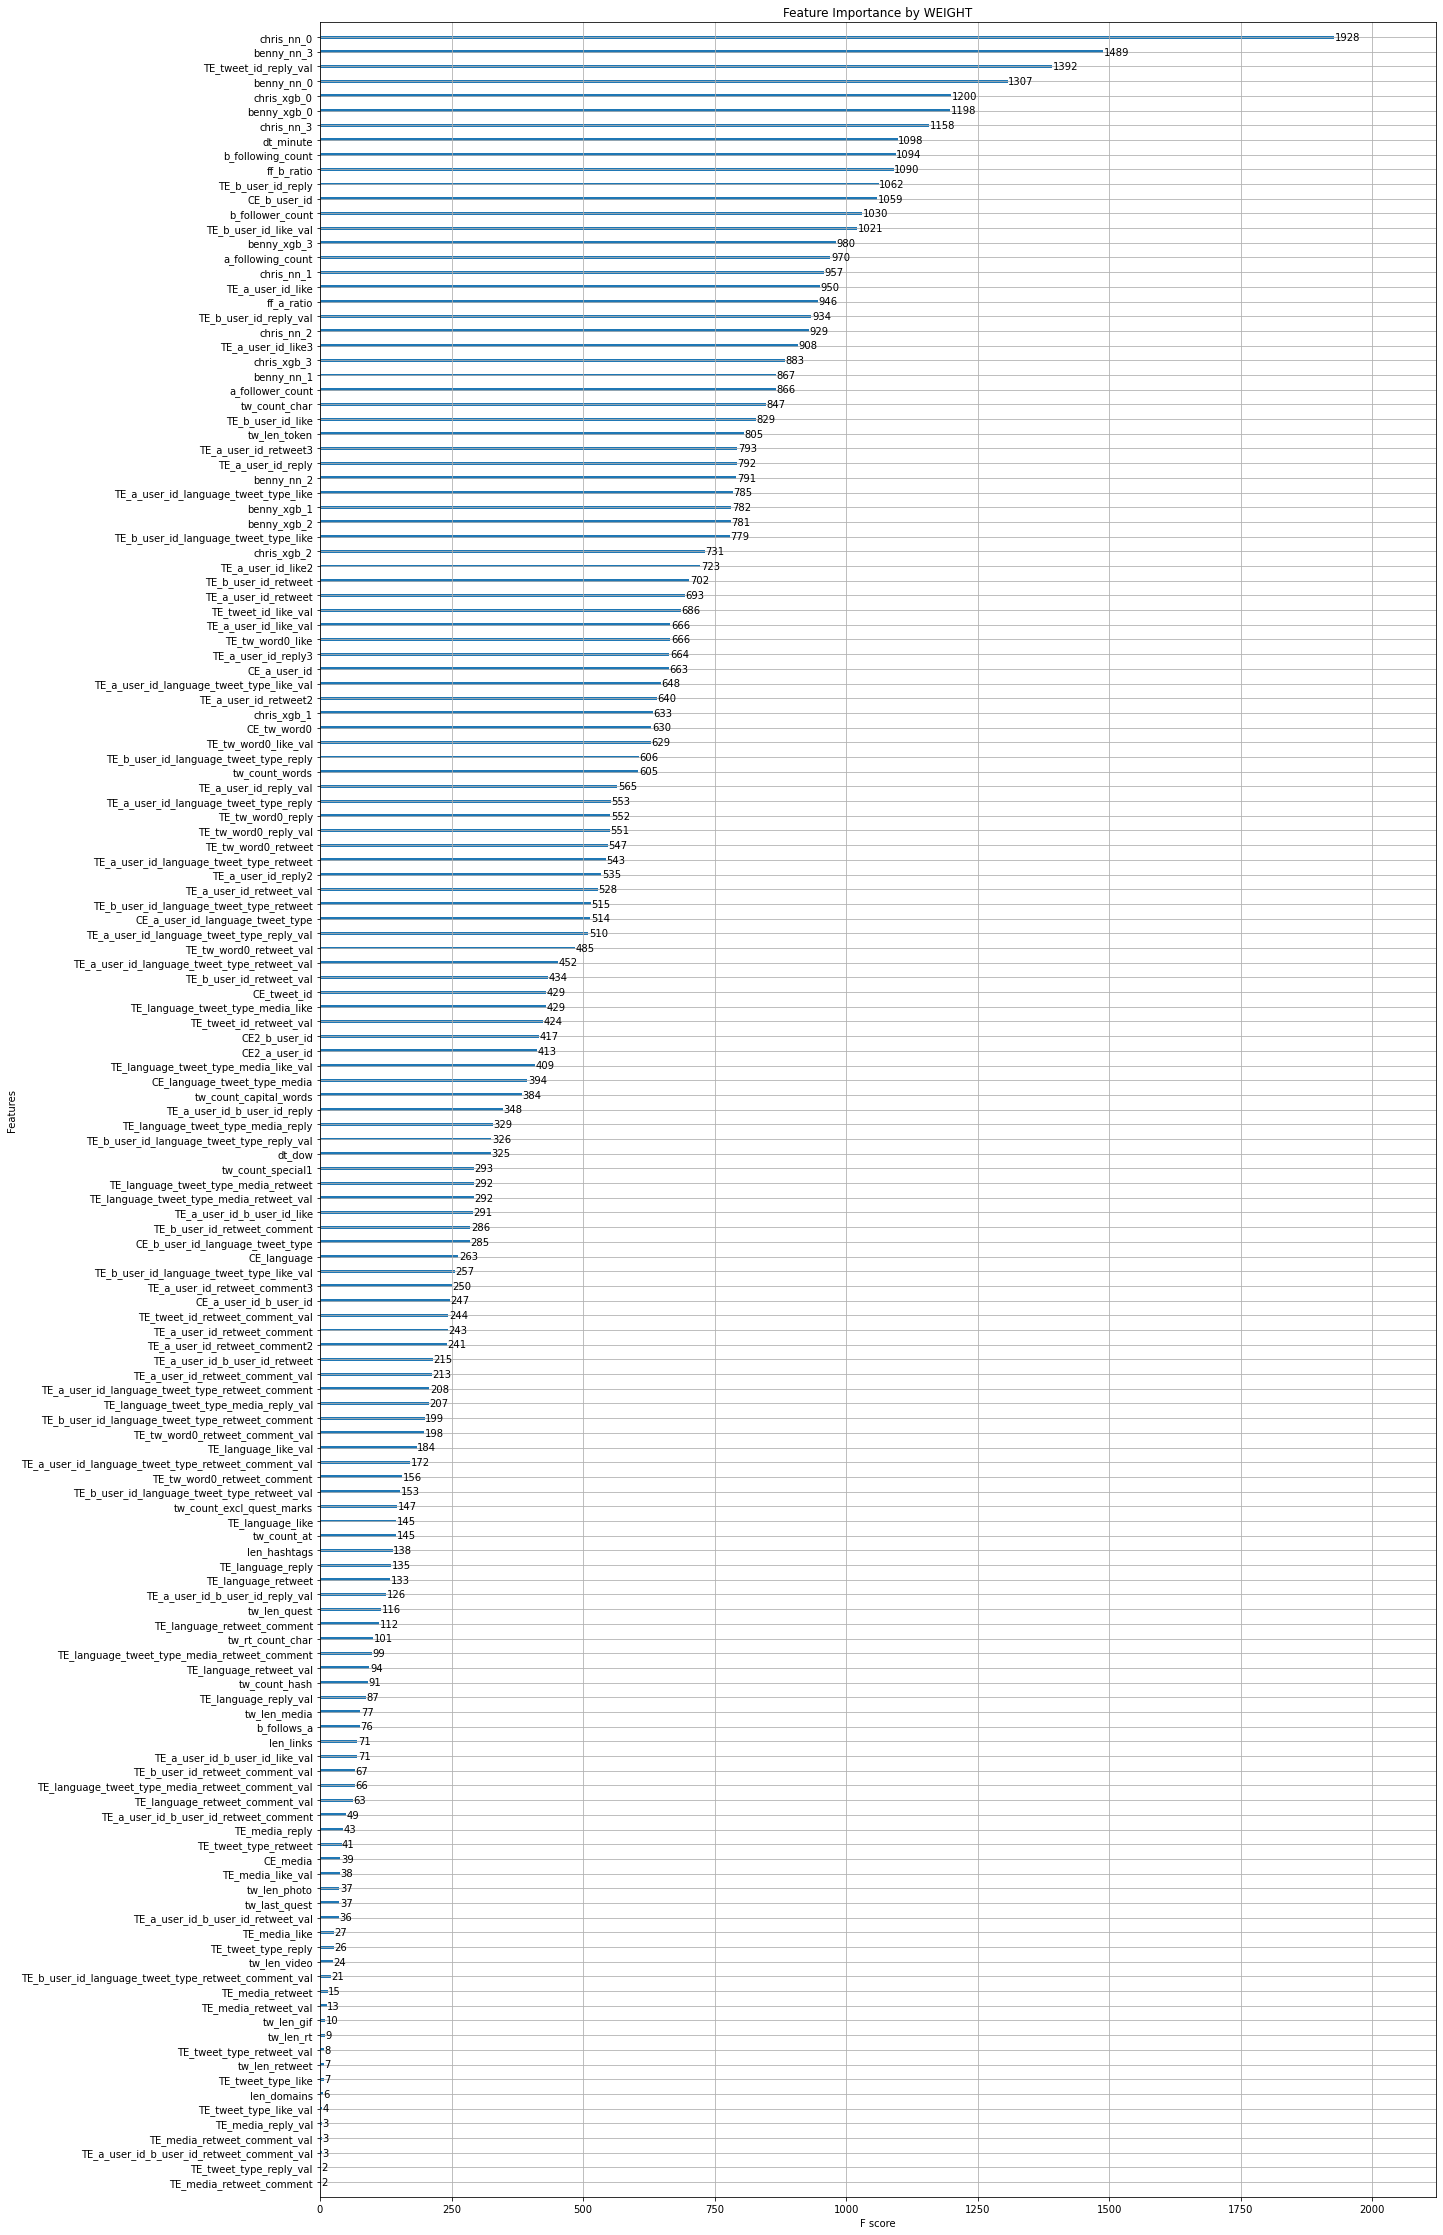

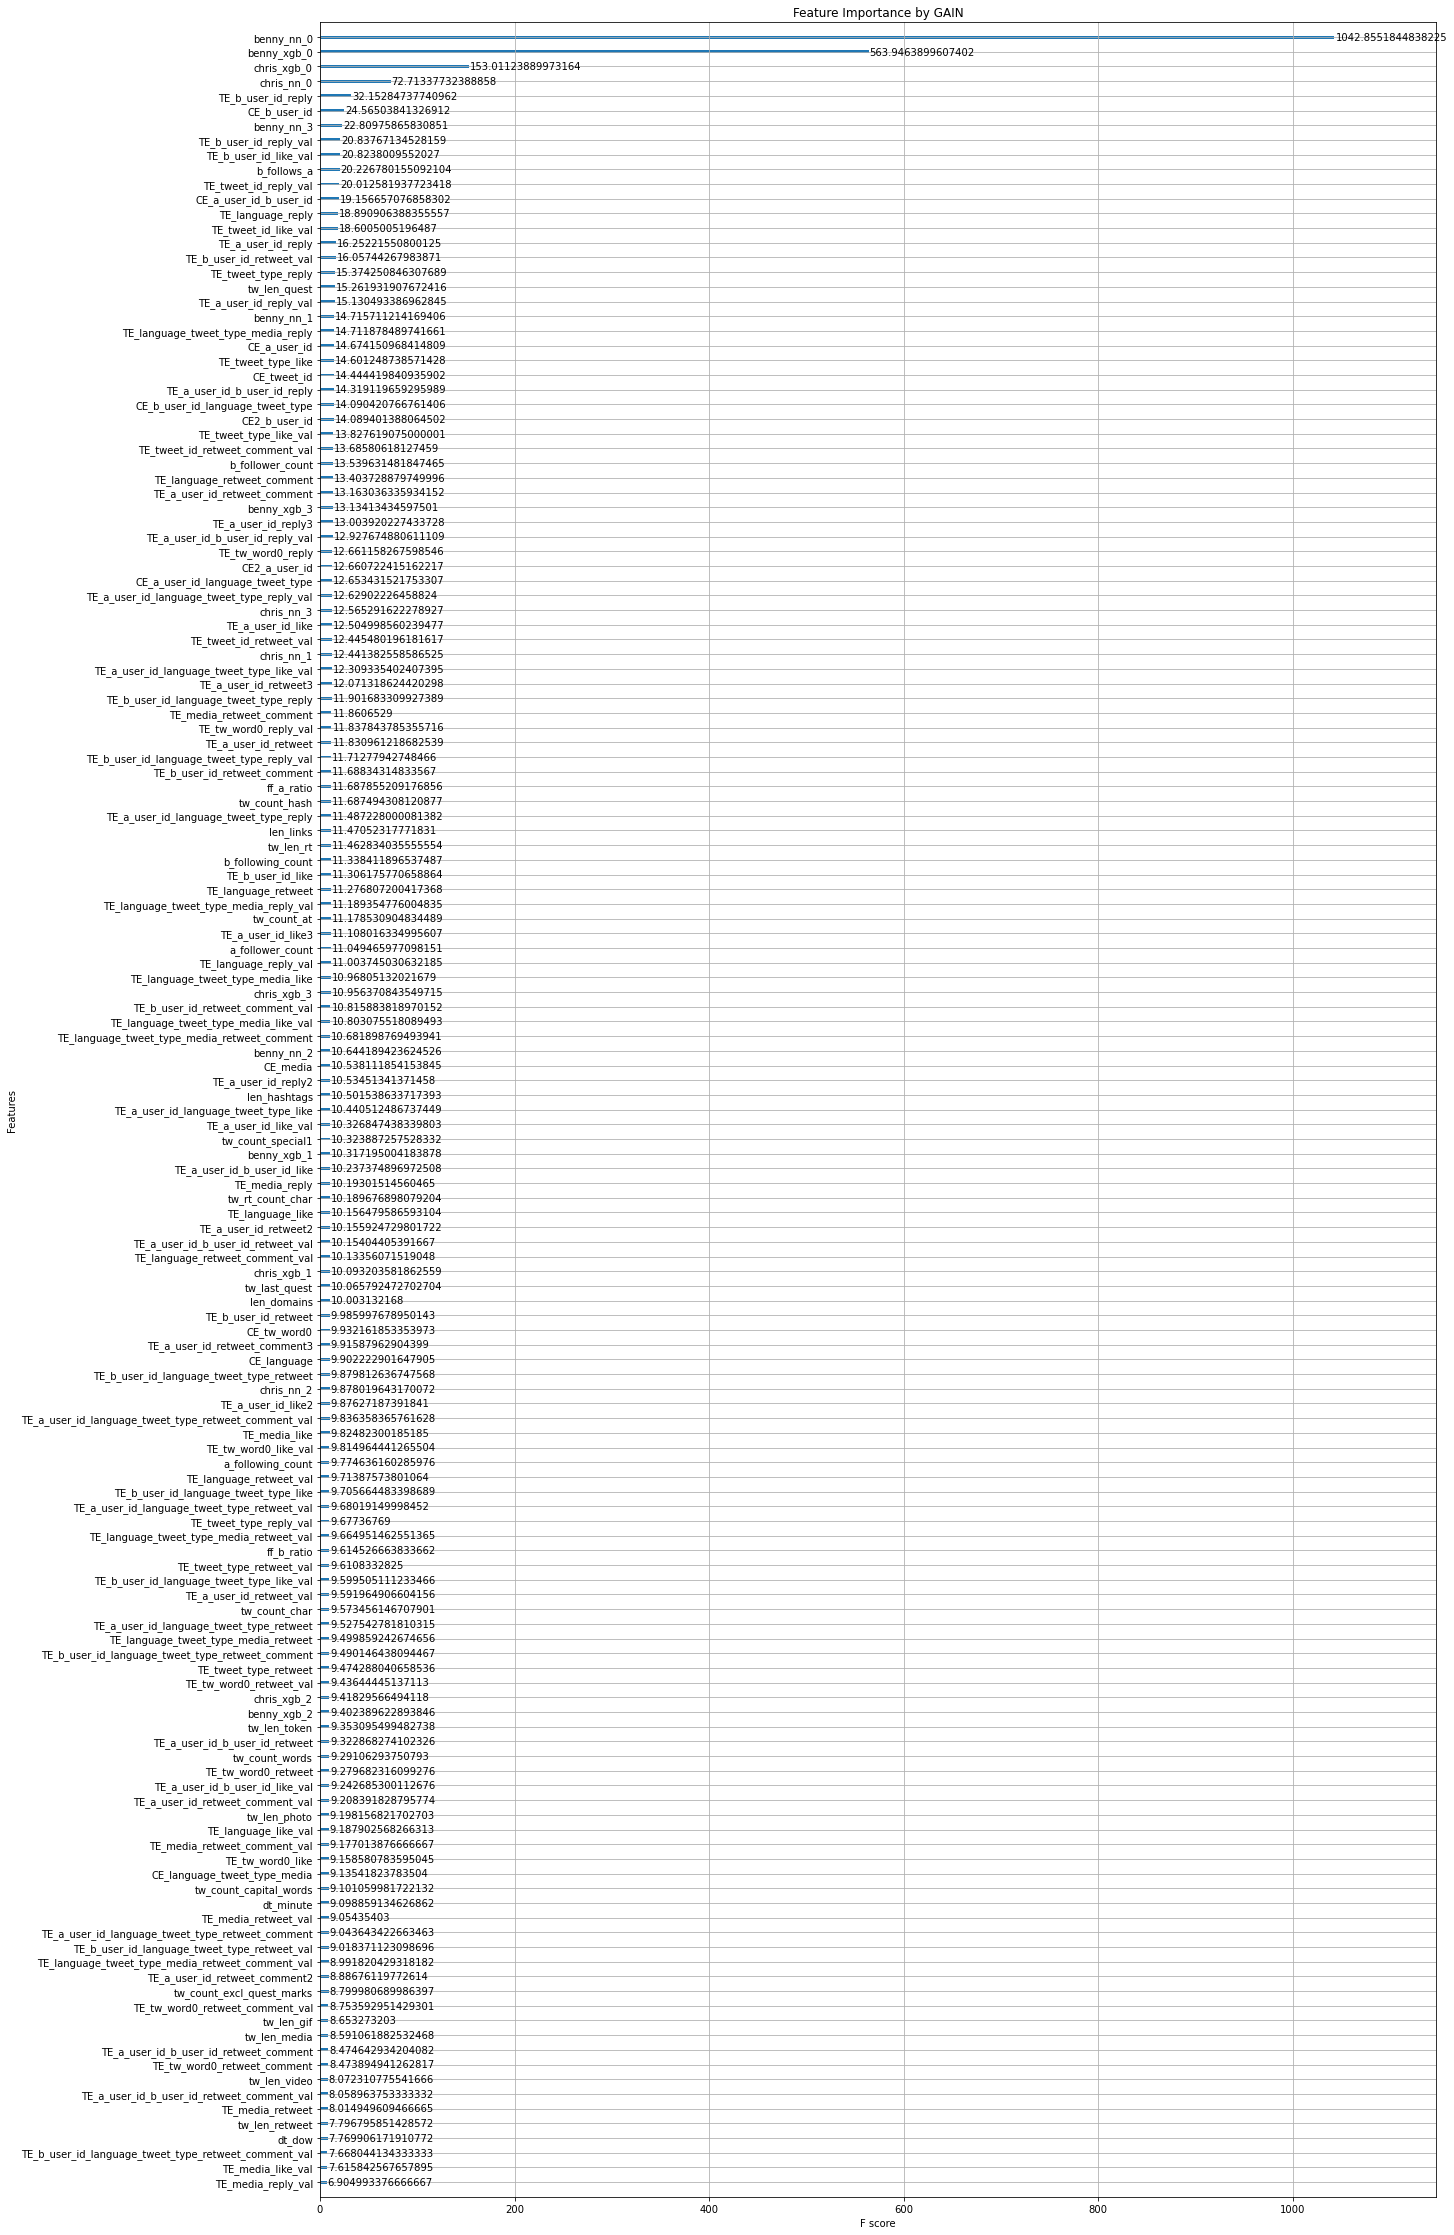

#########################
### retweet
#########################
[0]	train-auc:0.85867
[25]	train-auc:0.86696
[50]	train-auc:0.87082
[75]	train-auc:0.87343
[100]	train-auc:0.87516
[125]	train-auc:0.87648
[150]	train-auc:0.87755
[175]	train-auc:0.87843
[200]	train-auc:0.87924
[225]	train-auc:0.87994
[250]	train-auc:0.88055
[275]	train-auc:0.88124
[300]	train-auc:0.88181
[325]	train-auc:0.88237
[350]	train-auc:0.88289
[375]	train-auc:0.88348
[400]	train-auc:0.88396
[425]	train-auc:0.88442
[450]	train-auc:0.88486
[475]	train-auc:0.88528
[500]	train-auc:0.88575
[525]	train-auc:0.88620
[550]	train-auc:0.88662
[575]	train-auc:0.88709
[600]	train-auc:0.88751
[625]	train-auc:0.88794
[650]	train-auc:0.88837
[675]	train-auc:0.88874
[700]	train-auc:0.88916
[725]	train-auc:0.88955
[750]	train-auc:0.88994
[775]	train-auc:0.89034
[800]	train-auc:0.89070
[816]	train-auc:0.89097


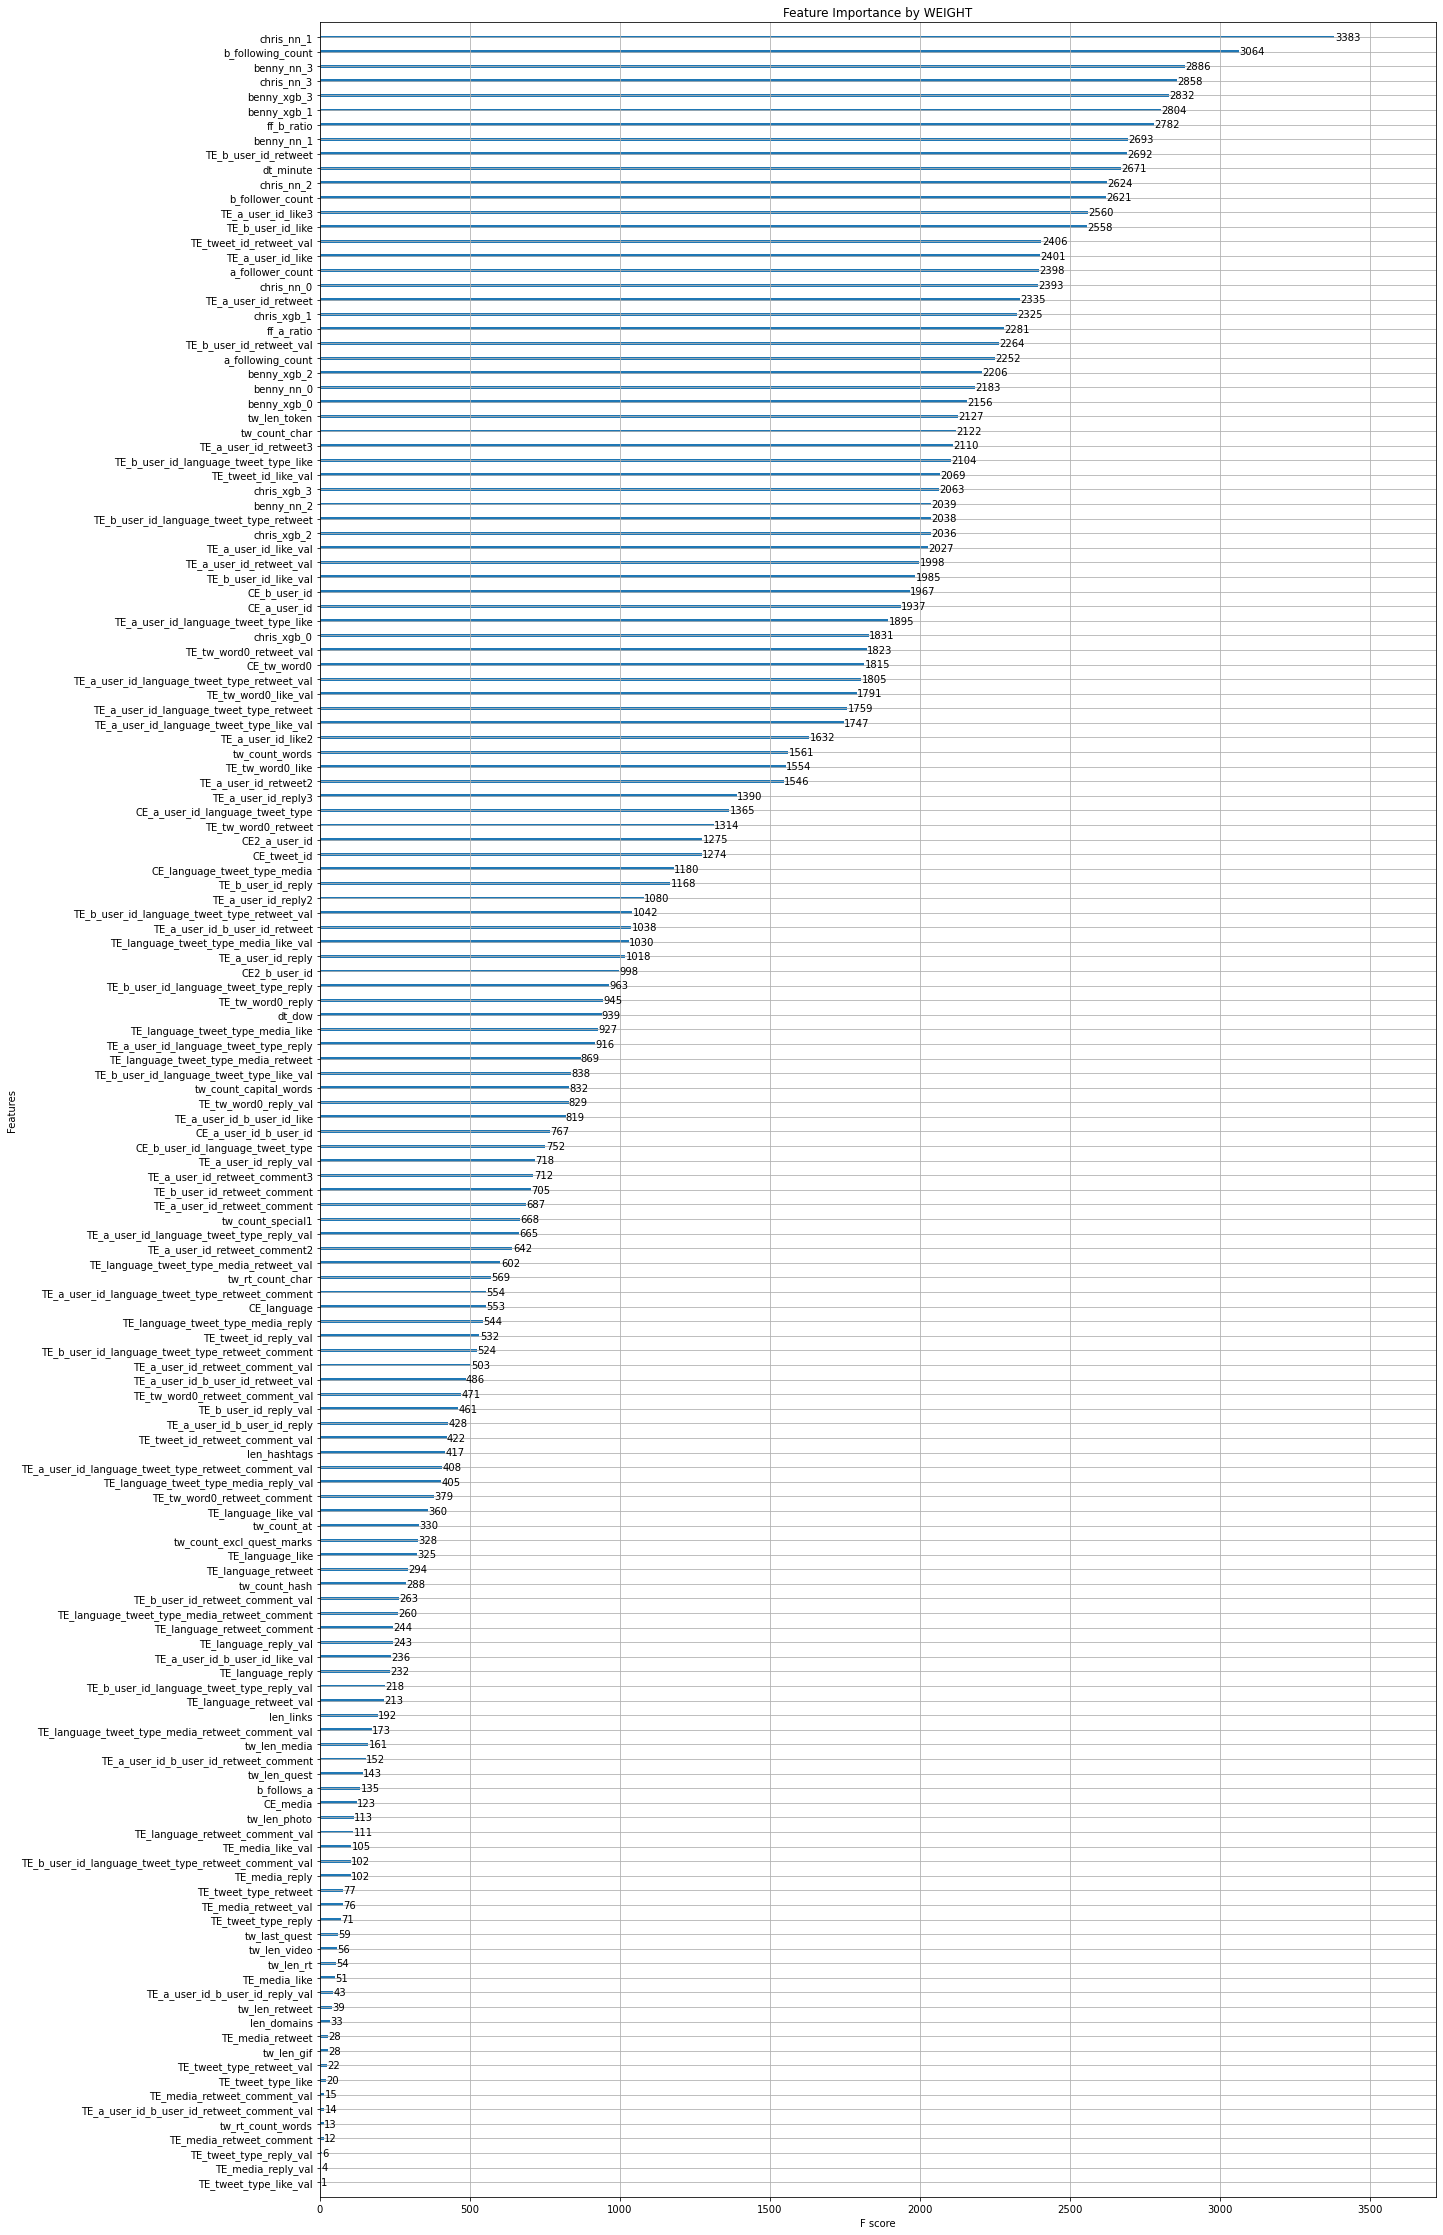

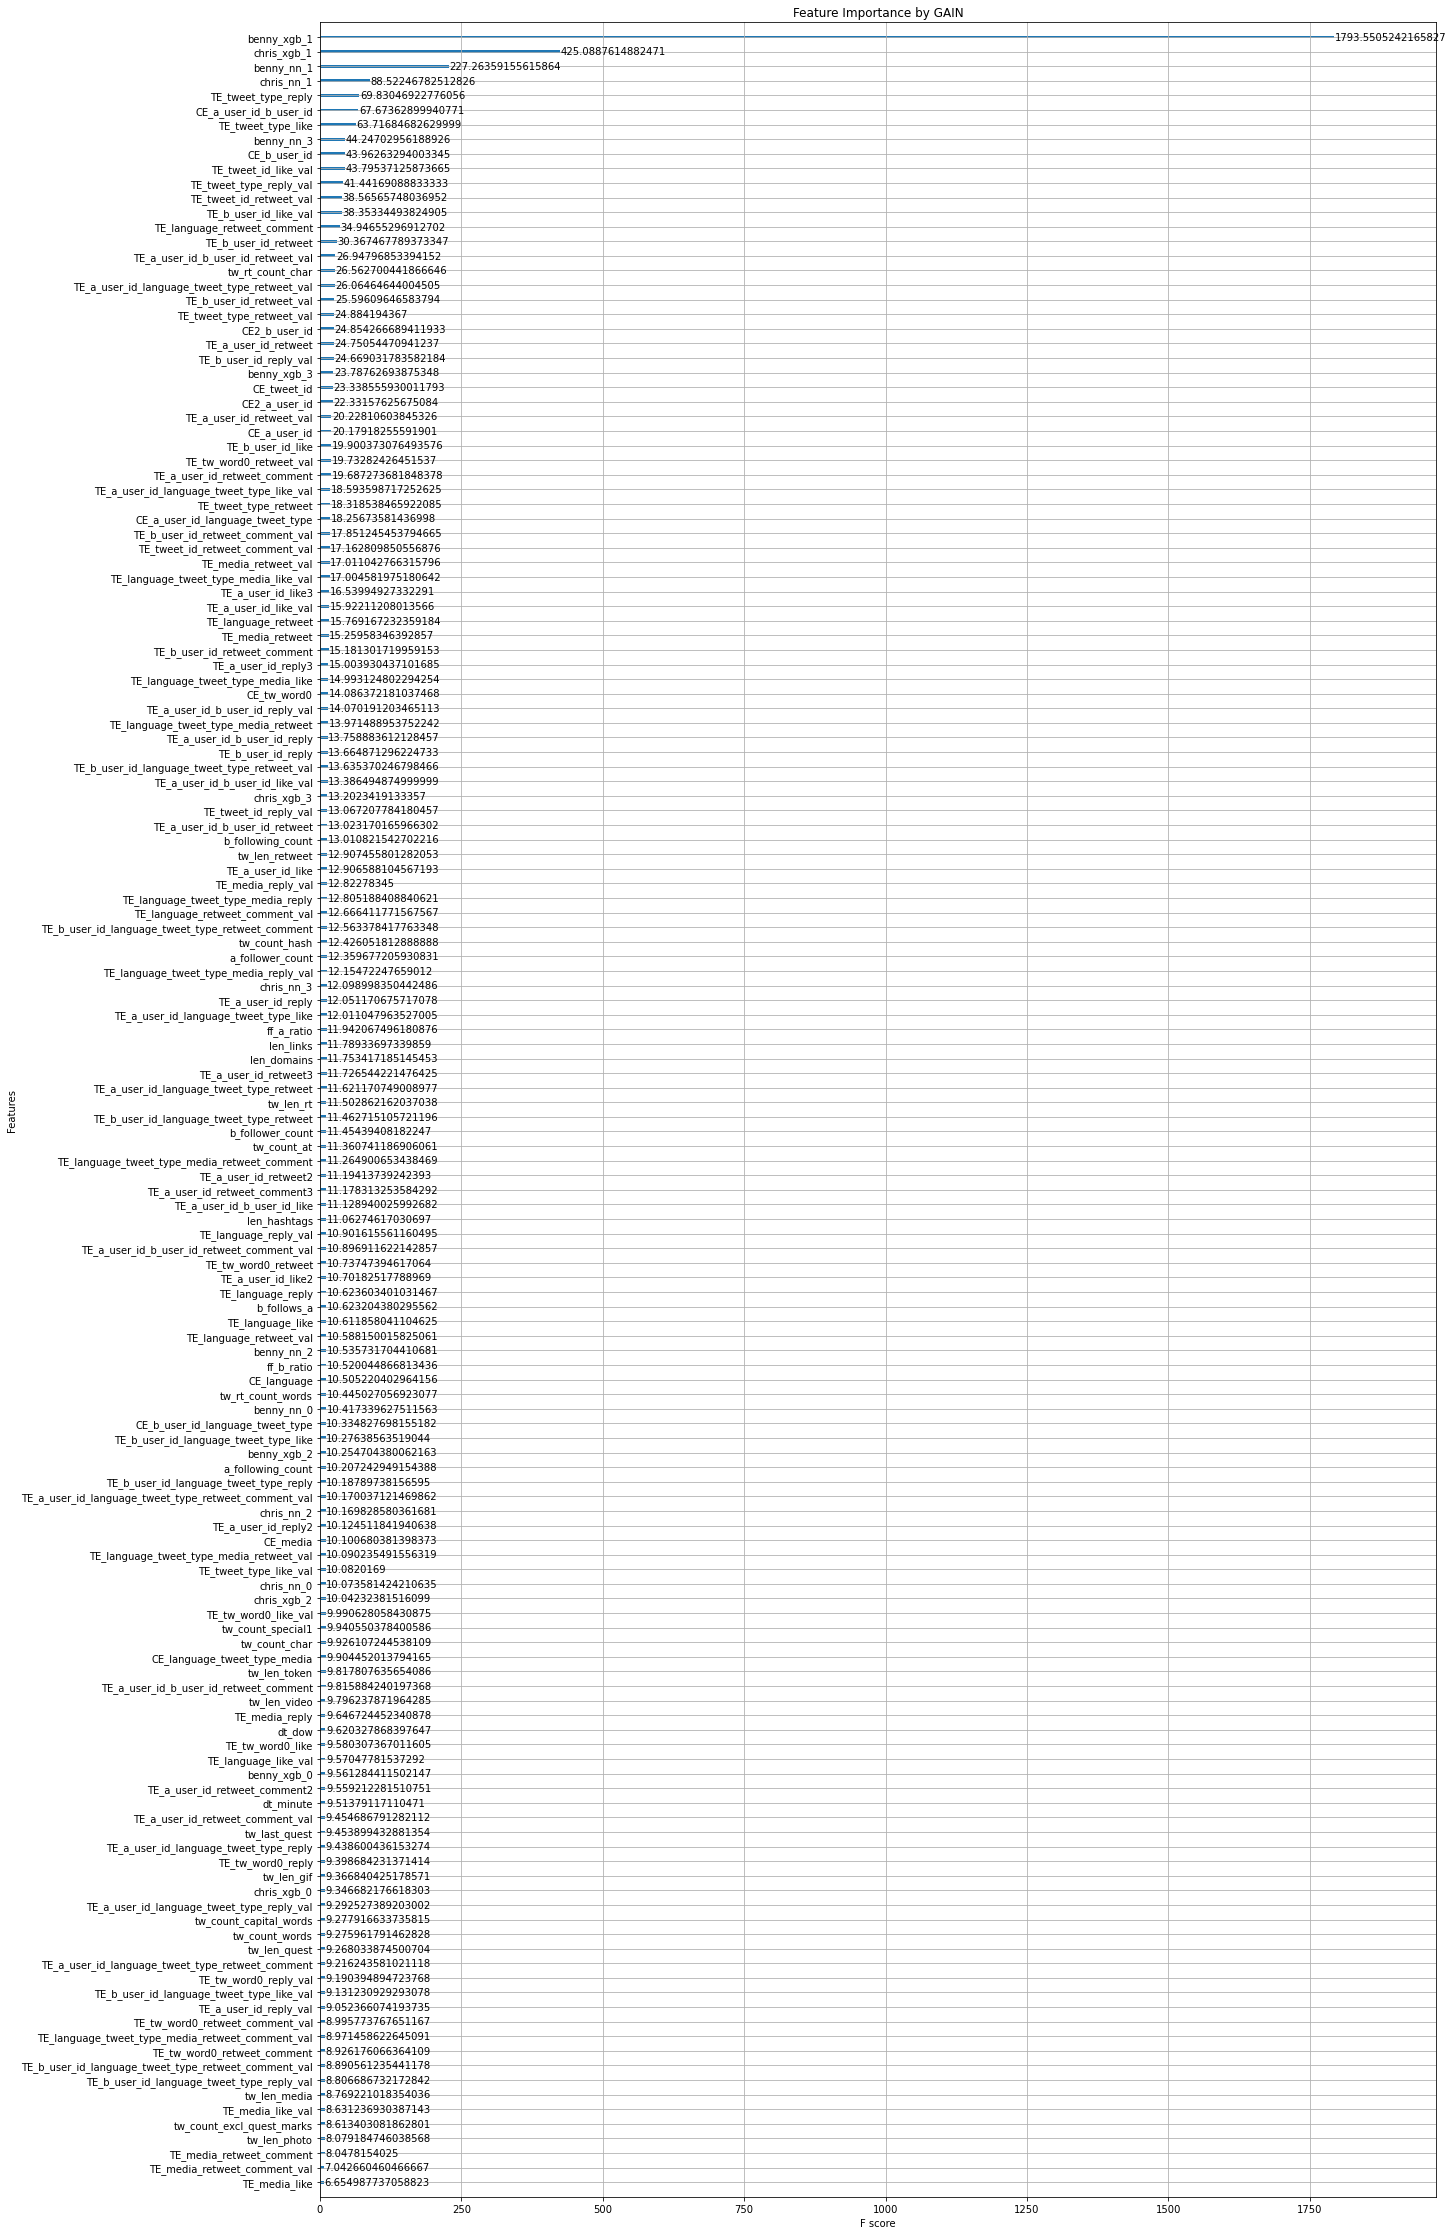

#########################
### retweet_comment
#########################
[0]	train-auc:0.83700
[25]	train-auc:0.85249
[50]	train-auc:0.86075
[75]	train-auc:0.87047
[100]	train-auc:0.87783
[125]	train-auc:0.88379
[150]	train-auc:0.88807
[175]	train-auc:0.89167
[200]	train-auc:0.89500
[202]	train-auc:0.89534


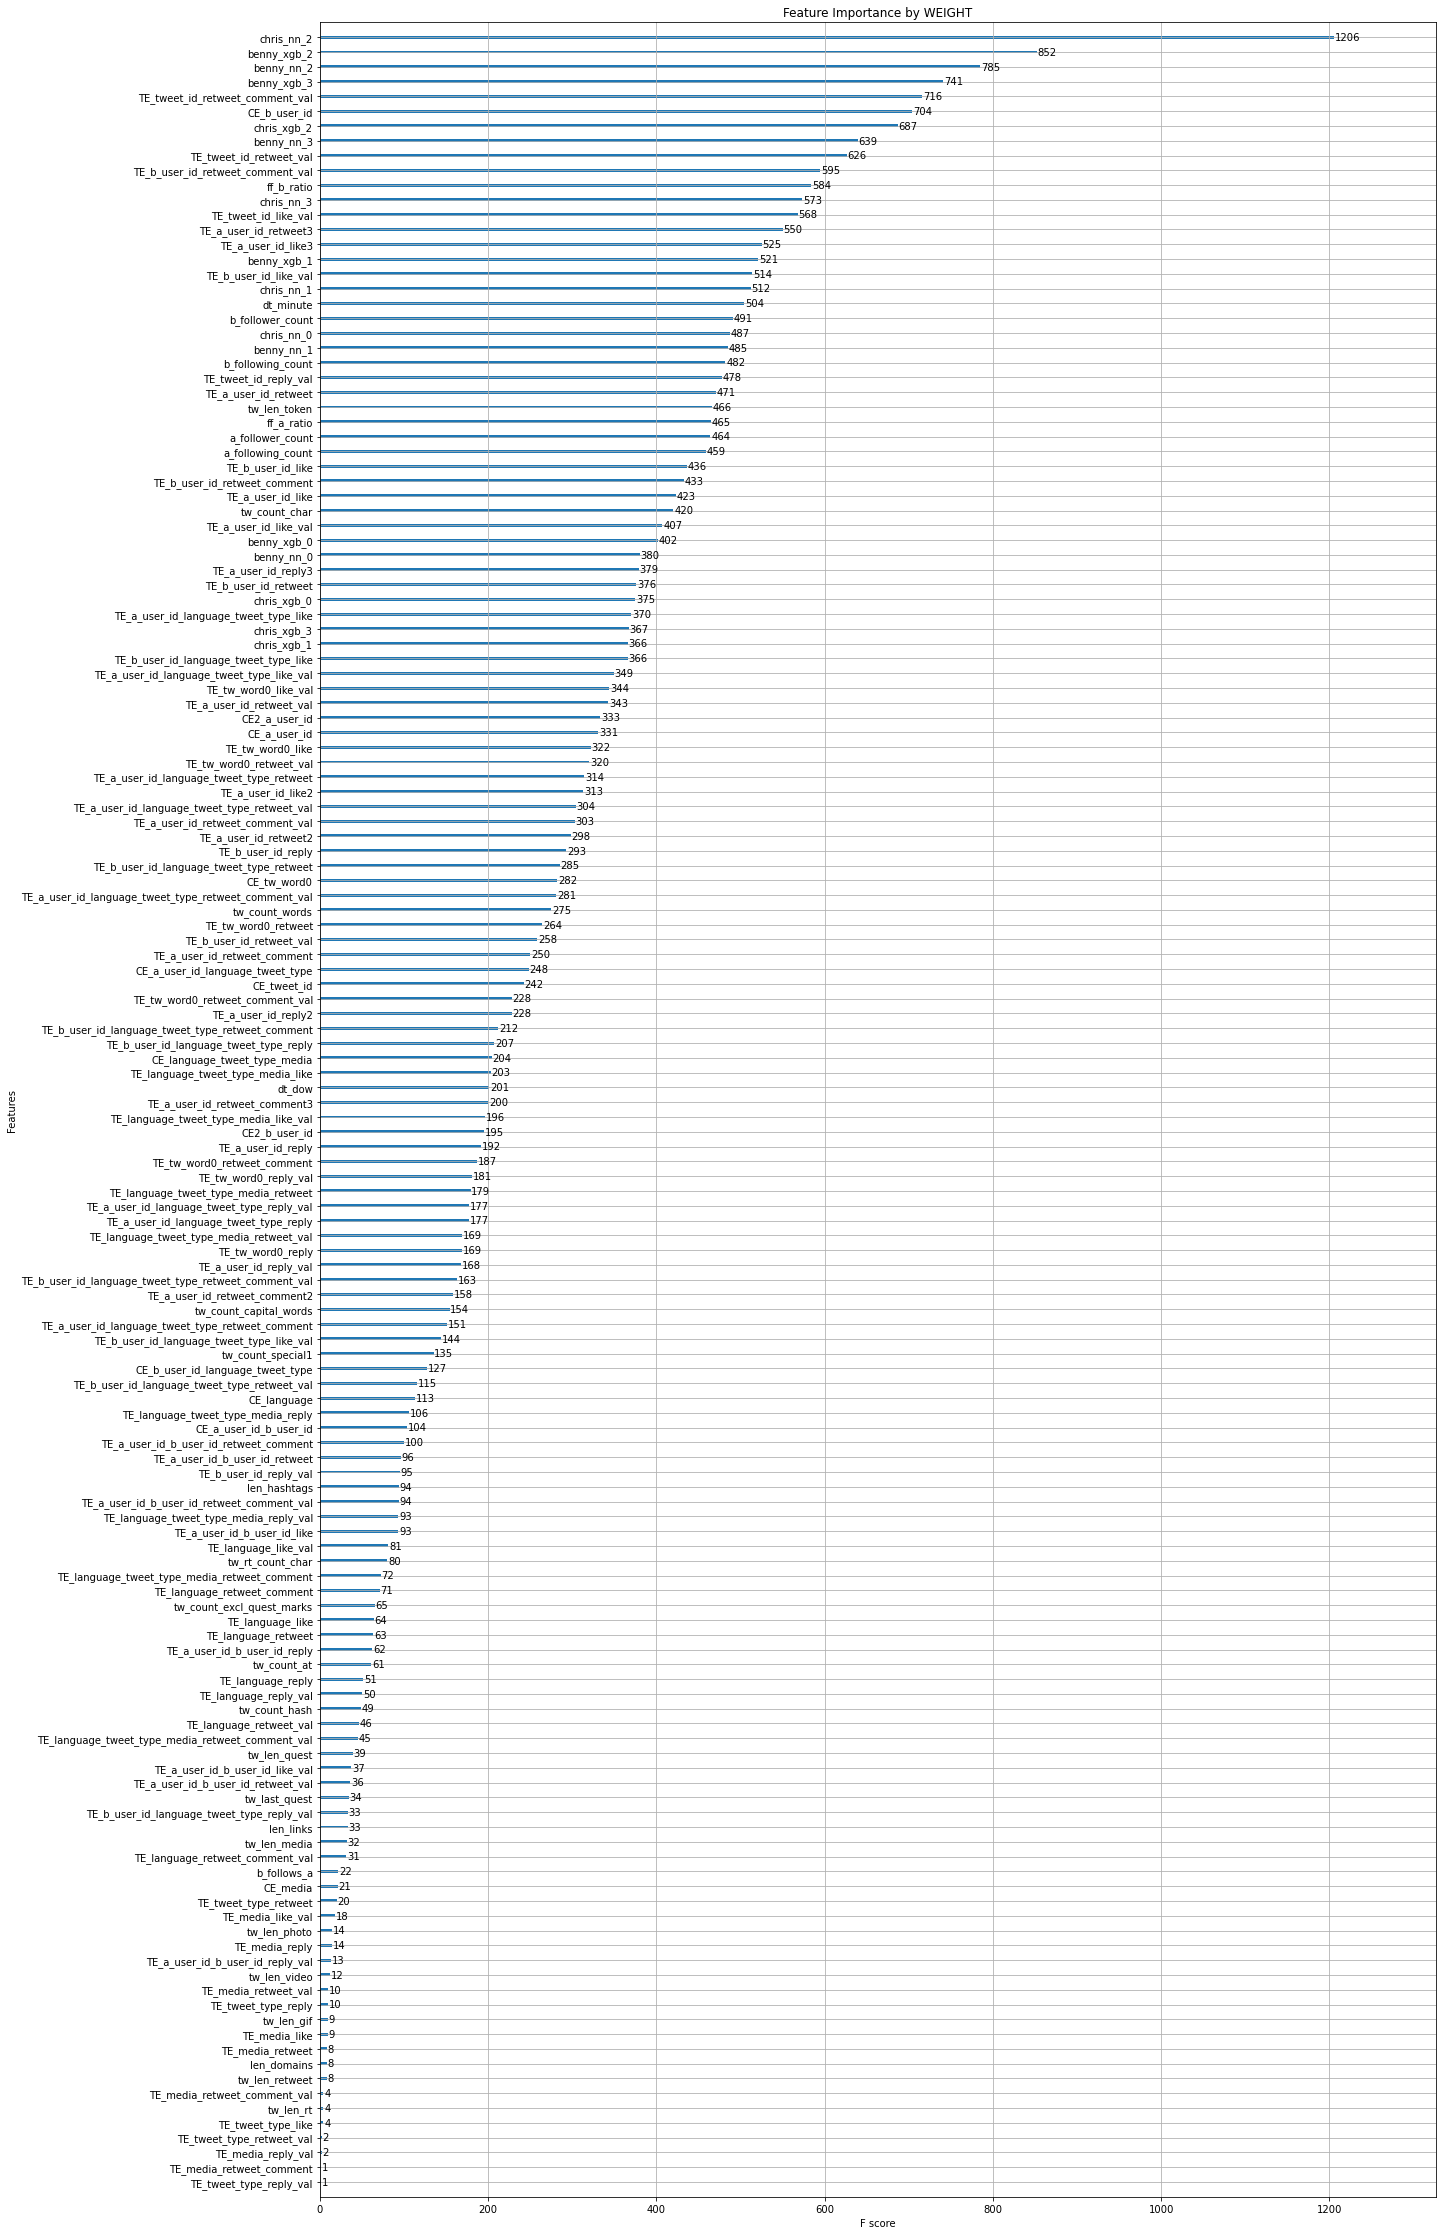

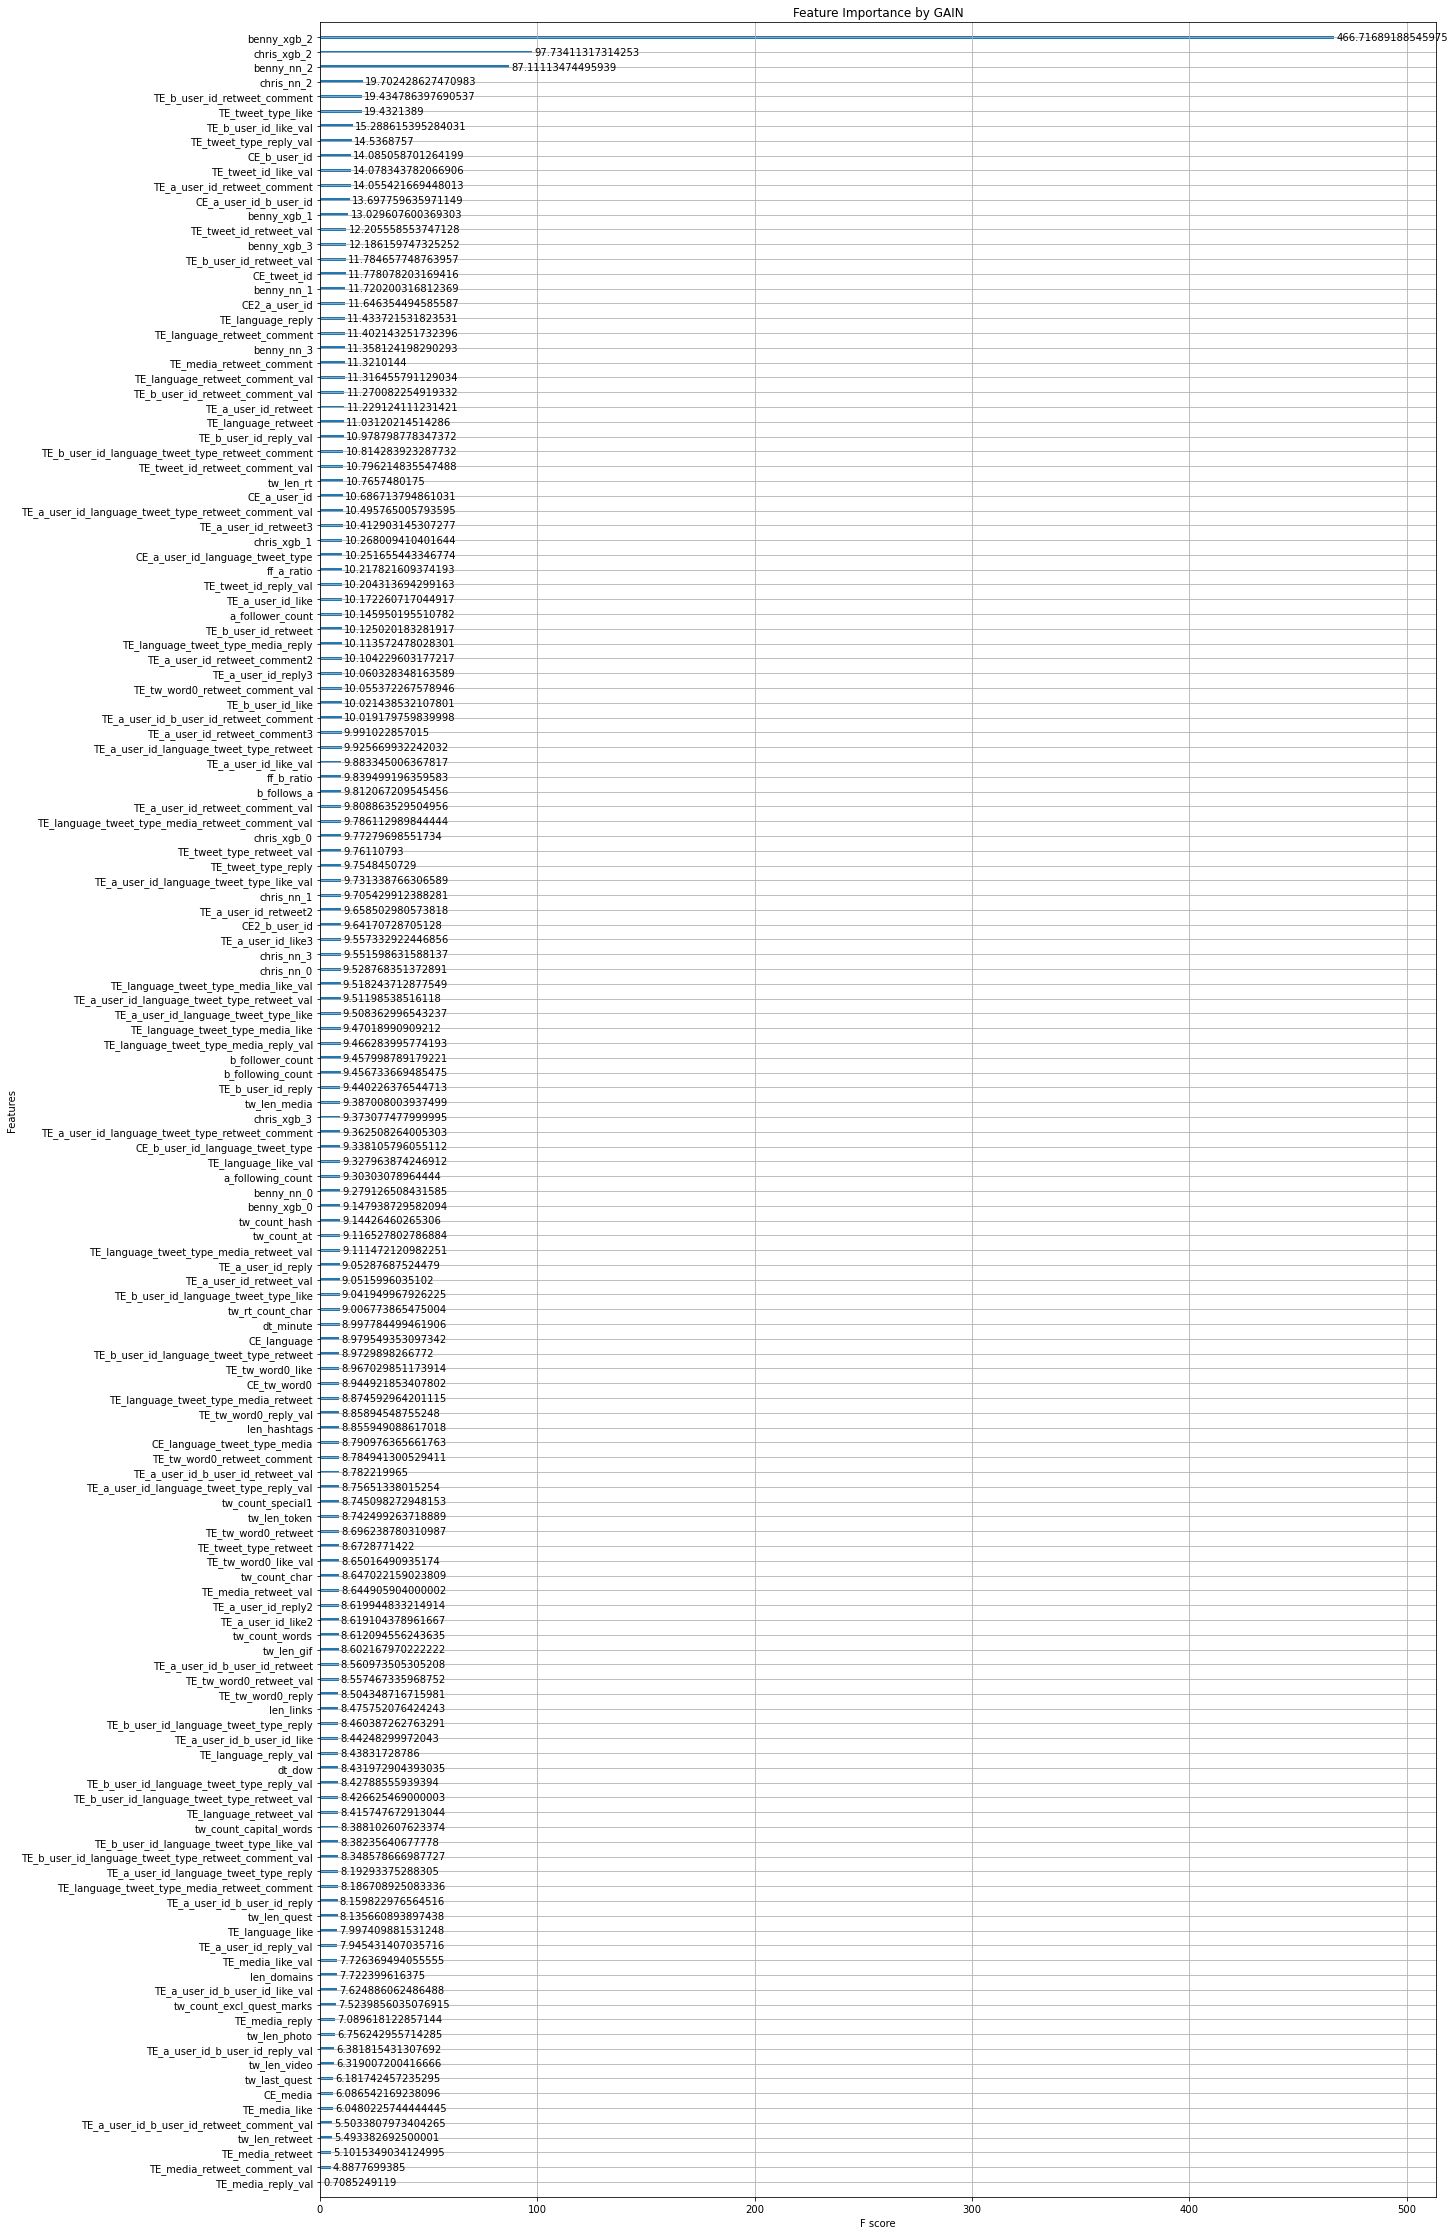

#########################
### like
#########################
[0]	train-auc:0.78855
[25]	train-auc:0.80422
[50]	train-auc:0.81019
[75]	train-auc:0.81325
[100]	train-auc:0.81515
[125]	train-auc:0.81656
[150]	train-auc:0.81754
[175]	train-auc:0.81839
[200]	train-auc:0.81918
[225]	train-auc:0.81987
[250]	train-auc:0.82050
[275]	train-auc:0.82107
[300]	train-auc:0.82161
[325]	train-auc:0.82209
[350]	train-auc:0.82255
[375]	train-auc:0.82301
[400]	train-auc:0.82344
[425]	train-auc:0.82382
[450]	train-auc:0.82422
[475]	train-auc:0.82460
[500]	train-auc:0.82499
[525]	train-auc:0.82528
[550]	train-auc:0.82560
[575]	train-auc:0.82596
[600]	train-auc:0.82631
[625]	train-auc:0.82660
[650]	train-auc:0.82692
[675]	train-auc:0.82722
[700]	train-auc:0.82756
[725]	train-auc:0.82784
[750]	train-auc:0.82816
[775]	train-auc:0.82846
[800]	train-auc:0.82873
[825]	train-auc:0.82902
[850]	train-auc:0.82930
[875]	train-auc:0.82958
[900]	train-auc:0.82987
[925]	train-auc:0.83013
[950]	train-auc:0.83040
[975]	tr

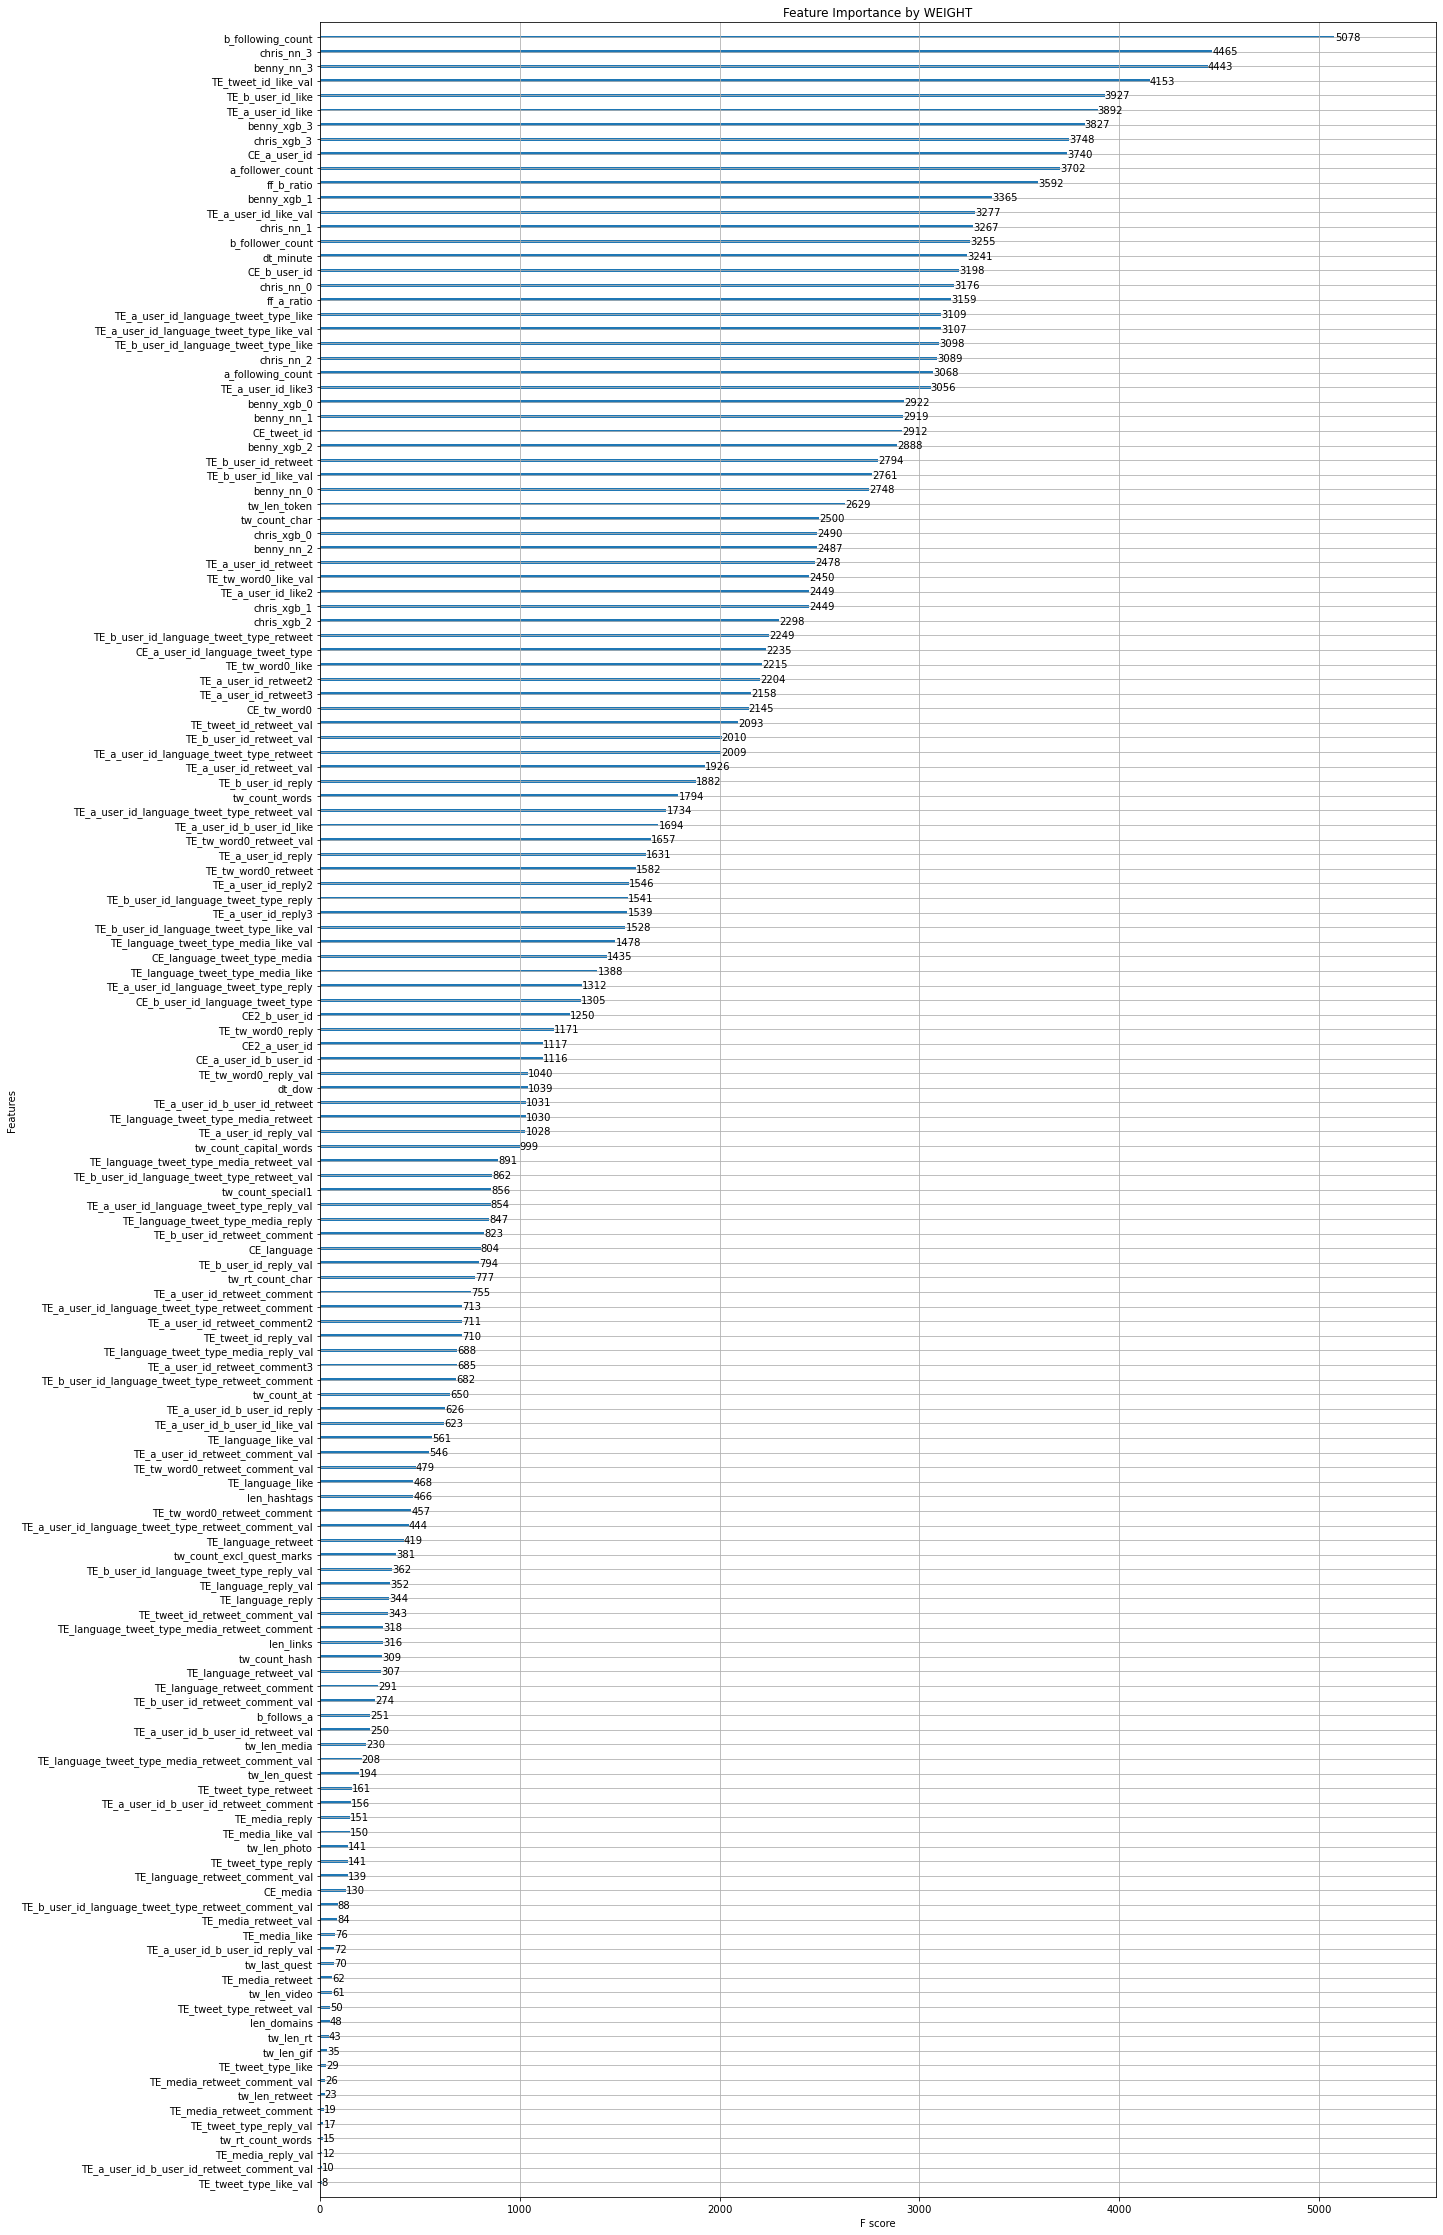

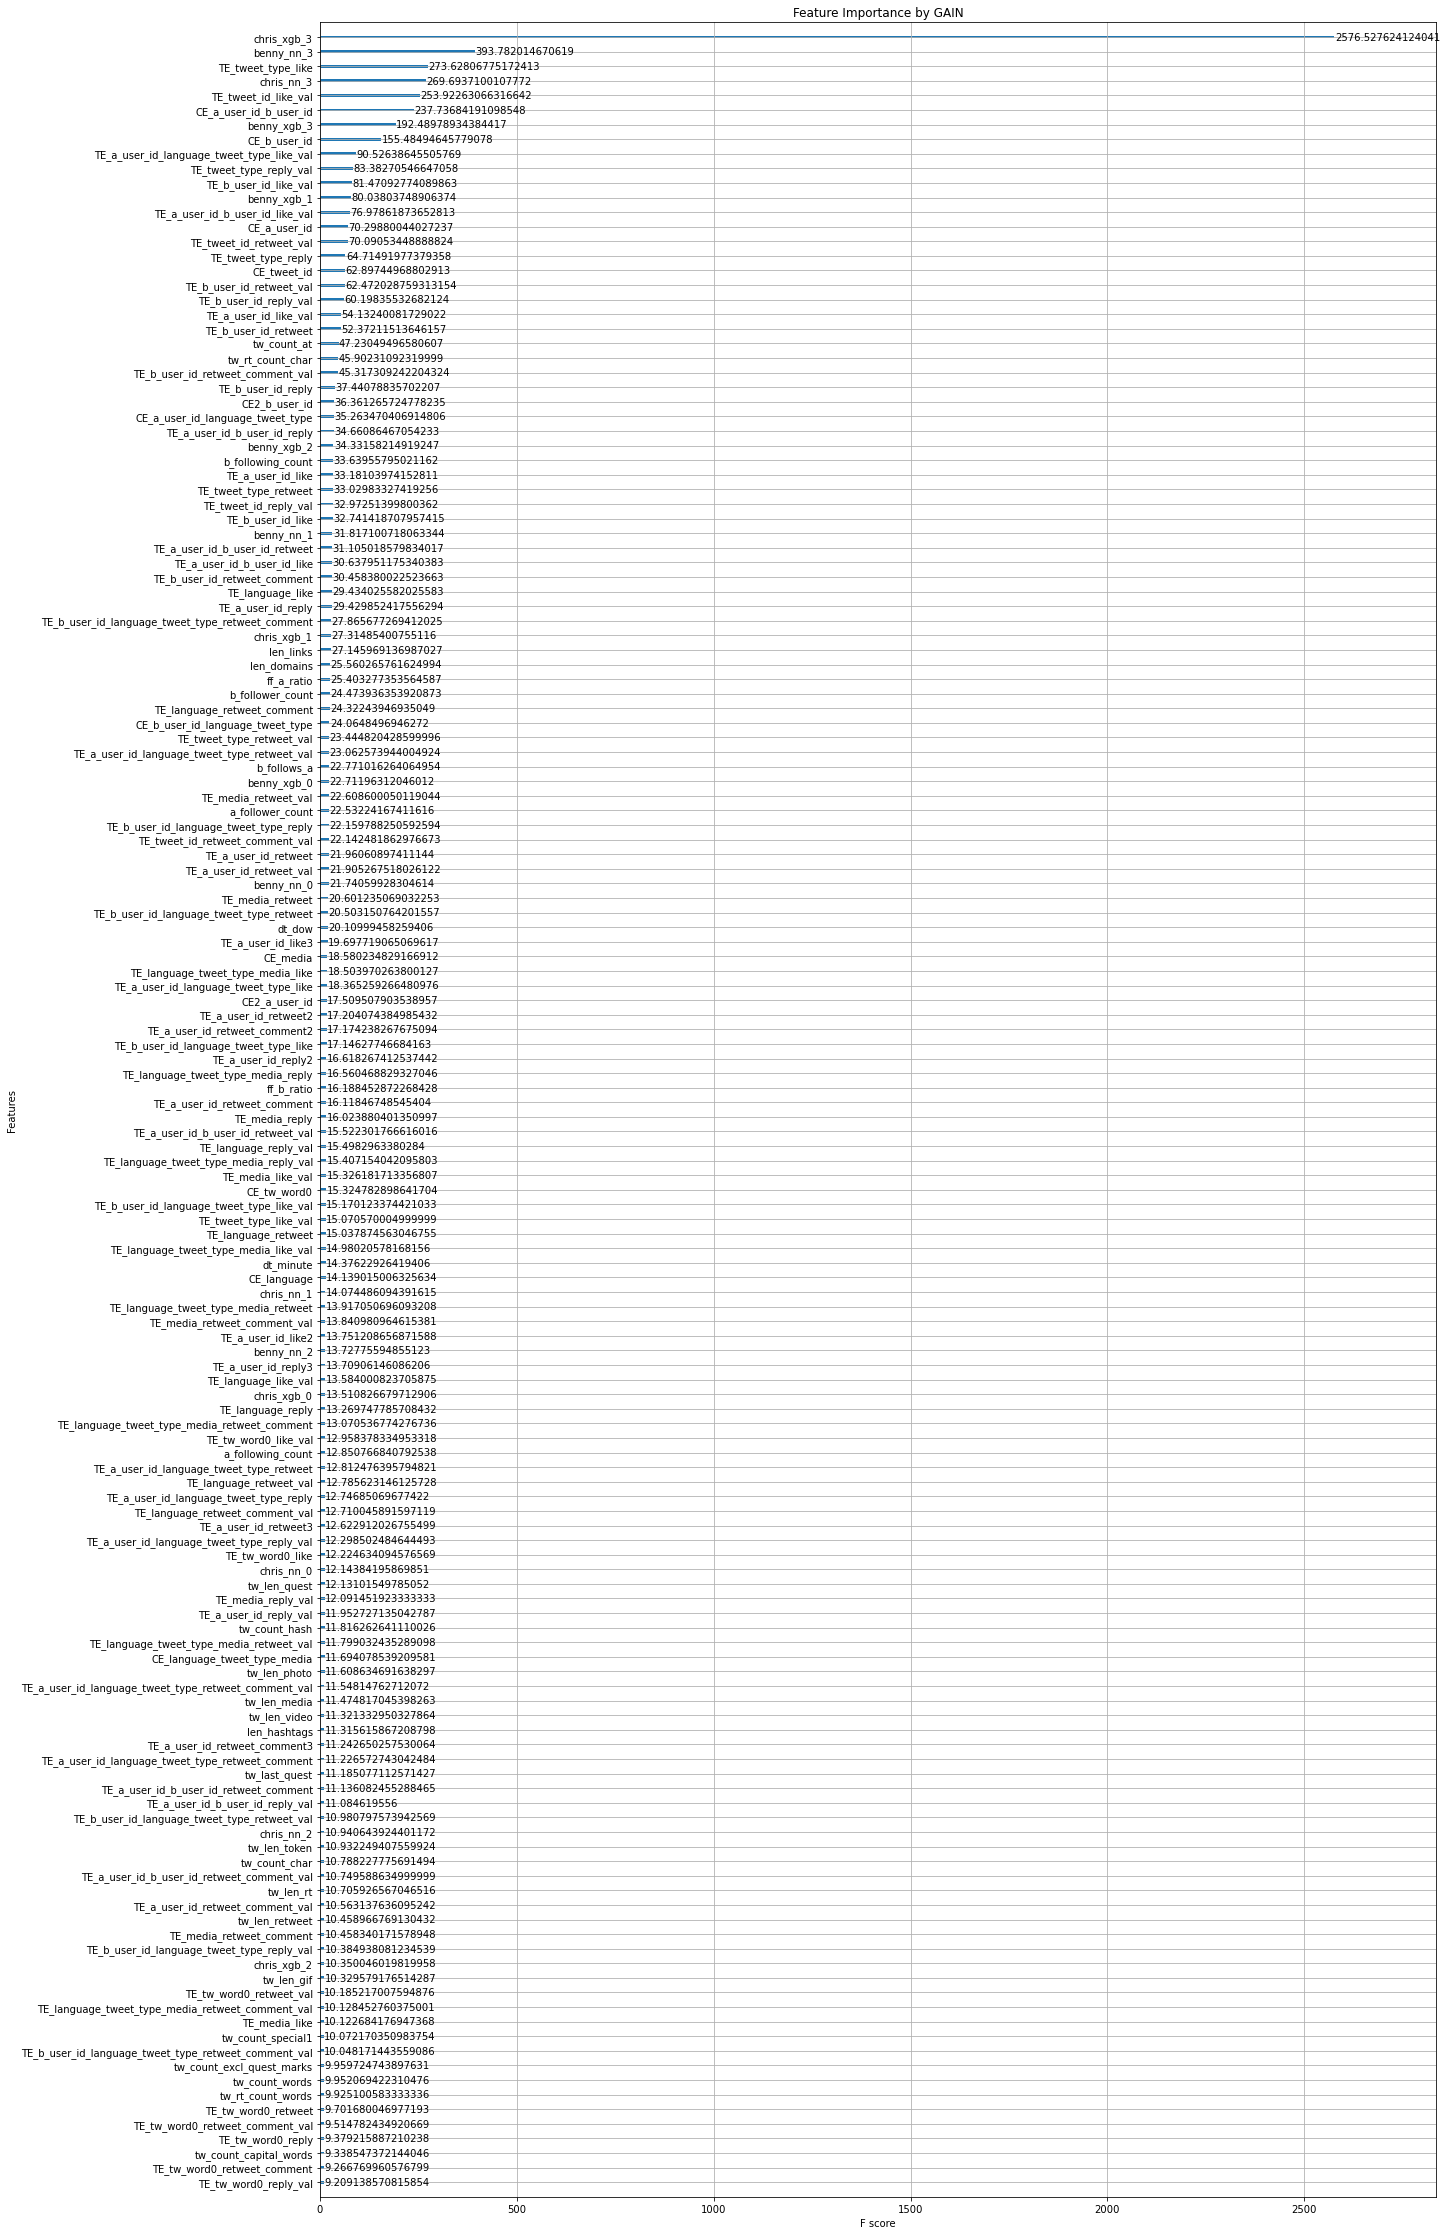

In [47]:
oof = np.zeros((len(valid),4))

for k in range(4):
    print('#'*25)
    print('###',TARGETS[k])
    print('#'*25)
    
    #FEATS2 = [f for f in FEATS if not f in RMV[k]]
    #print('Using',len(FEATS2),'features...')
    
    dtrain = xgb.DMatrix(data=train.loc[IDX,FEATS], label=train.loc[IDX,TARGETS[k]] )
    if not TRAIN_SUB: dvalid = xgb.DMatrix(data=valid[FEATS], label=valid[TARGETS[k]] )

    if TRAIN_SUB:
        model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train')],
                num_boost_round=ROUNDS[k],
                verbose_eval=25) 
        model.save_model('./m%i/XGB_%s_%s'%(VER,TARS[k],POSTFIX))
        gc.collect()
    else:
        model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=1000,
                early_stopping_rounds=25,
                #maximize=True,
                verbose_eval=50) 
                
        #model.save_model('./m%i/XGB_%s_%s'%(VER,TARGETS[k],POSTFIX))
        oof[:,k] = model.predict(dvalid)
        
    fig, ax1 = plt.subplots()
    fig.set_size_inches(20,40)
    xgb.plot_importance(model,ax1,importance_type='weight',title='Feature Importance by WEIGHT')
    plt.show()
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(20,40)
    xgb.plot_importance(model,ax1,importance_type='gain',title='Feature Importance by GAIN')
    plt.show()

# Compute Overfitted Val Score

In [48]:
oof = np.zeros((len(IDX),4))

for k in range(4):
    print('#'*25)
    print('###',TARGETS[k])
    print('#'*25)
    
    dtrain = xgb.DMatrix(data=train.loc[IDX,FEATS], label=train.loc[IDX,TARGETS[k]] )
    model = xgb.Booster()
    model.load_model('m%i/XGB_%s_a'%(VER,targets[k]))
    oof[:,k] = model.predict(dtrain)

#########################
### reply
#########################
#########################
### retweet
#########################
#########################
### retweet_comment
#########################
#########################
### like
#########################


# Computed Metrics on Train

In [49]:
from sklearn.metrics import precision_recall_curve, auc, log_loss, average_precision_score

def compute_prauc(pred, gt):
  prec, recall, thresh = precision_recall_curve(gt, pred)
  prauc = auc(recall, prec)
  return prauc

def calculate_ctr(gt):
  positive = len([x for x in gt if x == 1])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# FAST METRIC FROM GIBA
def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = np.mean(gt)     
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [50]:
train2 = train.loc[IDX].copy().reset_index(drop=True)

In [51]:
%%time
if TRAIN_SUB:
    tot=0; tot2 = 0
    for i in range(4):
        apg = 0; rceg = 0
        for j in range(5):
            #prauc = compute_prauc(oof[:,i], train[TARS[i]].values )
            idx = train2.group.values==j
            ap = average_precision_score( train2.loc[idx,TARS[i]].values, oof[idx,i] )
            rce   = compute_rce_fast(oof[idx,i], train2.loc[idx,TARS[i]].values )
            apg += ap/5.; rceg += rce/5.
        tot += rceg; tot2 += apg
        txt_ = f"{TARS[i]:20} AP:{apg:.5f} RCE:{rceg:.5f}"
        print(txt_)
    print()
    tt = 'Total'
    txt_ = f"{tt:20} AP:{tot2:.5f} RCE:{tot:.5f}"
    print(txt_)
    print()

reply                AP:0.30699 RCE:29.50974
retweet              AP:0.50093 RCE:32.12498
retweet_comment      AP:0.13066 RCE:22.12580
like                 AP:0.72473 RCE:24.06808

Total                AP:1.66331 RCE:107.82860

CPU times: user 30.4 s, sys: 1.12 s, total: 31.6 s
Wall time: 31.5 s
